# Importing Libraries

In [1]:
!pip install transformers
!pip install datasets
!pip install torchmetrics
!pip install optuna
!pip install -U "neptune[optuna]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 52.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pya

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel,AutoTokenizer,AdamW
from datasets import load_dataset
from tqdm.auto import tqdm
import numpy as np
import random
from torchmetrics.classification import BinaryAccuracy,MulticlassF1Score,MulticlassPrecision,MulticlassRecall,MulticlassAccuracy,BinaryConfusionMatrix
from torchmetrics.collections import MetricCollection
import optuna
from google.colab import userdata
import neptune
import uuid
import neptune.integrations.optuna as npt_utils
import  hashlib
import time
import math
import pickle
import matplotlib.pyplot as plt

# Setting up the GPU or CPU

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["NEPTUNE_API_TOKEN"] = userdata.get('NEPTUNE_API_TOKEN')
device = torch.device("cuda:0"  if torch.cuda.is_available() else "cpu")

# Define Variable Values

In [4]:
# @title Define Transformer Model Name
bert_model_name = "vinai/bertweet-base" # @param {type:"string"}

In [5]:
# @title Define Hugging Face Dataset Name
dataset_name = "krishan-CSE/Unified_Reduced_All" # @param {type:"string"}



In [6]:
# @title Define Neptuna Project Name
project_name='FYP-DCL/fyp-thushalya'# @param {type:"string"}
neptune_id=''# @param {type:"string"} #if you want to start a new study keep it blank

In [7]:
# @title Define Experiment Name
study_name = "DCL_Experiments_final_v1" # @param {type:"string"}



In [8]:
dataset_tag = dataset_name
model_tag = bert_model_name

##Setting up Neptuna

In [9]:
def load_optuna_states(run:neptune.Run,directory:str):
  run[f'{directory}/optuna_storage'].download()
  run[f'{directory}/sampler'].download()
  run[f'{directory}/pruner'].download()
  run.wait()

In [10]:
if neptune_id=='':
  study_id=str(hashlib.md5(str(time.time()).encode()).hexdigest()[:8])
  sweep_id = uuid.uuid1()
  run_study_level = neptune.init_run(project=project_name,capture_stdout=True,capture_stderr=True,capture_traceback=True, capture_hardware_metrics=True,tags=[dataset_tag , "hyper-parameter-tuning", model_tag],name=(study_name+'_'+study_id))
  run_study_level["sweep-id"] = str(sweep_id)
  run_study_level["sys/tags"].add("study-level")
else:
  run_study_level = neptune.init_run(with_id=neptune_id,project=project_name,capture_stdout=True,capture_stderr=True,capture_traceback=True, capture_hardware_metrics=True)
  name=run_study_level["sys/name"].fetch()
  run_study_level.wait()
  study_name,study_id = tuple(name.rsplit('_', 1))
  sweep_id=run_study_level["sweep-id"].fetch()
  load_optuna_states(run=run_study_level,directory="optuna")

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2327


In [11]:
#@title Define Transformer Model Tokenizer Max Padding Length
SEED = 1234
PADDING_MAX_LENGTH = 45  # @param {type:"integer"}


# Setting Random Seed for Reproducibility

In [12]:
def setup_seed(seed:int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [13]:
setup_seed(SEED)

# Loading Train,Dev Datasets

In [14]:
dataset = load_dataset(dataset_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/15872 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2121 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5128 [00:00<?, ? examples/s]

# Loading the Tokernizer for the Transformer Model

In [15]:
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


##Define the Tokenizer Function

In [16]:
def tokenize_function(examples):
    return tokenizer.batch_encode_plus(examples["text"], padding='max_length',max_length=PADDING_MAX_LENGTH,add_special_tokens=True,truncation=True)

## Tokenize the Dataset

In [17]:
dataset

DatasetDict({
    train: Dataset({
        features: ['dataset', 'text', 'labels', 'Average_Word_Length', 'Lexical_Diversity', 'Capital_Letters_Count', 'Hashtag_Frequency', 'Mention_Frequency', 'count_emojis', 'special_chars_count', 'Stop_Word_Frequency', 'Noun_Count', 'Verb_Count', 'Participle_Count', 'Interjection_Count', 'Pronoun_Count', 'Preposition_Count', 'Adverb_Count', 'Conjunction_Count', 'Readability_Score', 'URL_Frequency', 'AGR', 'CON', 'EXT', 'NEU', 'OPN', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 15872
    })
    validation: Dataset({
        features: ['dataset', 'text', 'labels', 'Average_Word_Length', 'Lexical_Diversity', 'Capital_Letters_Count', 'Hashtag_Frequency', 'Mention_Frequency', 'count_emojis', 'special_chars_count', 'Stop_Word_Frequency', 'Noun_Count', 'Verb_Count', 'Participle_Count', 'Interjection_Count', 'Pronoun_Count', 'Preposition_Count', 'Adverb_Count', 'Conjun

In [18]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/15872 [00:00<?, ? examples/s]

Map:   0%|          | 0/2121 [00:00<?, ? examples/s]

Map:   0%|          | 0/5128 [00:00<?, ? examples/s]

In [19]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['dataset', 'text', 'labels', 'Average_Word_Length', 'Lexical_Diversity', 'Capital_Letters_Count', 'Hashtag_Frequency', 'Mention_Frequency', 'count_emojis', 'special_chars_count', 'Stop_Word_Frequency', 'Noun_Count', 'Verb_Count', 'Participle_Count', 'Interjection_Count', 'Pronoun_Count', 'Preposition_Count', 'Adverb_Count', 'Conjunction_Count', 'Readability_Score', 'URL_Frequency', 'AGR', 'CON', 'EXT', 'NEU', 'OPN', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15872
    })
    validation: Dataset({
        features: ['dataset', 'text', 'labels', 'Average_Word_Length', 'Lexical_Diversity', 'Capital_Letters_Count', 'Hashtag_Frequency', 'Mention_Frequency', 'count_emojis', 'special_chars_count', 'Stop_Word_Frequency', 'Noun_Count', 'Verb_Count', 'Participle_Count', 'Interjection_Count', 'Pronoun_Cou

## Remove Unwanted Coloumns

In [20]:
tokenized_datasets=tokenized_datasets.remove_columns(['text','dataset'])

In [21]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'Average_Word_Length', 'Lexical_Diversity', 'Capital_Letters_Count', 'Hashtag_Frequency', 'Mention_Frequency', 'count_emojis', 'special_chars_count', 'Stop_Word_Frequency', 'Noun_Count', 'Verb_Count', 'Participle_Count', 'Interjection_Count', 'Pronoun_Count', 'Preposition_Count', 'Adverb_Count', 'Conjunction_Count', 'Readability_Score', 'URL_Frequency', 'AGR', 'CON', 'EXT', 'NEU', 'OPN', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15872
    })
    validation: Dataset({
        features: ['labels', 'Average_Word_Length', 'Lexical_Diversity', 'Capital_Letters_Count', 'Hashtag_Frequency', 'Mention_Frequency', 'count_emojis', 'special_chars_count', 'Stop_Word_Frequency', 'Noun_Count', 'Verb_Count', 'Participle_Count', 'Interjection_Count', 'Pronoun_Count', 'Preposition_Count', 'Adverb_Coun

## Format the coloumns

In [22]:
tokenized_datasets=tokenized_datasets.with_format("torch")

# Define the Dual Contrastive Learning Architecture



In [23]:
class DCLArchitecture(nn.Module):
    def __init__(self,dropout:float,bert_model_name:str='bert-base-cased'):
        super(DCLArchitecture, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.dim = 768
        self.dense = nn.Linear(self.dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self,batch_tokenized, if_train=False):
        input_ids = batch_tokenized['input_ids']
        attention_mask = batch_tokenized['attention_mask']
        bert_output = self.bert(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        bert_cls_hidden_state = bert_output[1]

        if if_train:
            bert_cls_hidden_state_aug = self.dropout(bert_cls_hidden_state)
            bert_cls_hidden_state = torch.cat((bert_cls_hidden_state, bert_cls_hidden_state_aug), dim=1).reshape(-1, self.dim)
        else:
            bert_cls_hidden_state = self.dropout(bert_cls_hidden_state)

        linear_output = self.dense(bert_cls_hidden_state)
        linear_output = linear_output.squeeze(1)

        return bert_cls_hidden_state, linear_output

## Define Focal Loss

In [24]:
class FocalLoss(nn.Module):
    def __init__(self, alpha:float=0.4, gamma:float=2, size_average:bool=True):
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        self.size_average = size_average

    def forward(self, pred, target):

        device = target.device
        self.alpha = self.alpha.to(device)

        pred = nn.Sigmoid()(pred)
        pred = pred.view(-1, 1)
        target = target.view(-1, 1)
        pred = torch.cat((1-pred, pred), dim=1)

        class_mask = torch.zeros(pred.shape[0], pred.shape[1]).to(device)
        class_mask.scatter_(1, target.view(-1, 1).long(), 1.)
        probs = (pred * class_mask).sum(dim=1).view(-1, 1)
        probs = probs.clamp(min=0.0001, max=1.0)

        log_p = probs.log()
        alpha = torch.ones(pred.shape[0], pred.shape[1]).to(device)
        alpha[:, 0] = alpha[:, 0] * (1 - self.alpha)
        alpha[:, 1] = alpha[:, 1] * self.alpha
        alpha = (alpha * class_mask).sum(dim=1).view(-1, 1)

        batch_loss = -alpha * (torch.pow((1 - probs), self.gamma)) * log_p

        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()

        return loss

## Define Unsupervised Contrastive loss

In [25]:
def simcse_loss(batch_emb,temp_1:float):
    batch_size = batch_emb.size(0)
    y_true = torch.cat([torch.arange(1, batch_size, step=2, dtype=torch.long).unsqueeze(1),
                        torch.arange(0, batch_size, step=2, dtype=torch.long).unsqueeze(1)],
                       dim=1).reshape([batch_size,]).to(device)
    norm_emb = F.normalize(batch_emb, dim=1, p=2)
    sim_score = torch.matmul(norm_emb, norm_emb.transpose(0,1))
    sim_score = sim_score - (torch.eye(batch_size) * 1e12).to(device)
    sim_score = sim_score / temp_1
    loss_func = nn.CrossEntropyLoss()
    loss = loss_func(sim_score, y_true)

    return loss


## Define Supervised Contrastive loss

In [26]:
def sup_simcse_loss(batch_emb, label,temp_2:float):
    n = batch_emb.size(0)

    similarity_matrix = F.cosine_similarity(batch_emb.unsqueeze(1), batch_emb.unsqueeze(0), dim=2)
    mask = torch.ones_like(similarity_matrix) * (label.expand(n, n).eq(label.expand(n, n).t()))

    mask_no_sim = torch.ones_like(mask) - mask
    mask_dui_jiao_0 = ((torch.ones(n,n) - torch.eye(n,n)) * 1e12).to(device)
    similarity_matrix = torch.exp(similarity_matrix/temp_2)
    similarity_matrix = similarity_matrix * mask_dui_jiao_0

    sim = mask*similarity_matrix
    no_sim = similarity_matrix - sim
    no_sim_sum = torch.sum(no_sim , dim=1)
    no_sim_sum_expend = no_sim_sum.repeat(n, 1).T

    sim_sum  = sim + no_sim_sum_expend
    loss = torch.div(sim , sim_sum)
    loss = mask_no_sim + loss + (torch.eye(n, n)/1e12).to(device)
    loss = -torch.log(loss)
    loss = torch.sum(torch.sum(loss, dim=1))/(2*n)
    return loss

# Fine Tuning the Model

In [27]:
optuna_storage_location="content/optuna_storage.db"

## Format the Labels

In [28]:
def copy_label(labels):
    labels = labels.unsqueeze(1)
    labels = torch.cat((labels, labels), dim=1).reshape(-1, 1).squeeze(1)
    return labels

In [29]:
def is_supported_values(value):
  if not math.isinf(value) and not math.isnan(value):
    return True
  else:
    return False

## Define Training Loop

In [30]:
def training_loop(model, train_dataloader,optimizer,criteon,device,temp_1:float,temp_2:float,lamda:float,run_trial_level):
    accuracy_metric = BinaryAccuracy()
    accuracy_metric.to(device)
    progress_bar = tqdm(range(len(train_dataloader)))
    model.train()
    total_train_loss = 0.0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = copy_label(batch["labels"])
        emb, pred = model(batch, if_train=True)
        loss = criteon(pred, labels.float())
        loss_sim = simcse_loss(emb,temp_1=temp_1)
        loss_supsim = sup_simcse_loss(emb, labels,temp_2=temp_2)
        total_train_loss += loss.item()

        loss_value=loss.item()
        if is_supported_values(loss_value):
          run_trial_level["train/batch/loss"].append(loss_value)
        if is_supported_values(loss_sim):
          run_trial_level["train/batch/Unsupervised_Contrastive_loss"].append(loss_sim)
        if is_supported_values(loss_supsim):
          run_trial_level["train/batch/supervised_Contrastive_loss"].append(loss_supsim)

        pred_sig = torch.sigmoid(pred)

        preds_detach=torch.round(pred_sig.detach())

        batch_level_accuracy=accuracy_metric(preds_detach,labels)

        if is_supported_values(batch_level_accuracy.item()):
          run_trial_level["train/batch/accuracy"].append(batch_level_accuracy.item())
        loss = loss + lamda*(loss_sim + loss_supsim)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    average_epoch_train_loss = total_train_loss / len(train_dataloader)  # Compute average epoch loss
    train_accuracy =  accuracy_metric.compute()
    accuracy_metric.reset()
    return average_epoch_train_loss,train_accuracy


## Define Validation Loop

In [31]:
def validation_loop(model, dev_dataloader,criteon, device,average='macro'):
    collection_metric = MetricCollection(
          BinaryAccuracy(),
          MulticlassPrecision(num_classes=2,average=average),
          MulticlassRecall(num_classes=2,average=average),
          MulticlassF1Score(num_classes=2,average=average),
          BinaryConfusionMatrix()
    )
    collection_metric.to(device)
    model.eval()
    total_dev_loss = 0.0
    for batch in dev_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]

        with torch.no_grad():
            emb, pred = model(batch , False)
            loss = criteon(pred, labels.float())
            pred_sig = torch.round(torch.sigmoid(pred))
        nan_exist = torch.isnan(pred_sig).any().item()
        if nan_exist:
          collection_metric.reset()
          return None
        total_dev_loss += loss.item()
        collection_metric.update(pred_sig,labels)
    average_epoch_dev_loss = total_dev_loss / len(dev_dataloader)  # Compute average epoch loss
    result = collection_metric.compute()
    result["Loss"]=average_epoch_dev_loss
    result["BinaryConfusionMatrix"],_=collection_metric.BinaryConfusionMatrix.plot()
    collection_metric.reset()
    return result

## Define Test Loop

In [32]:
def test_loop(model, test_dataloader,criteon, device,average:str="macro"):
    collection_metric = MetricCollection(
          BinaryAccuracy(),
          MulticlassPrecision(num_classes=2,average=average),
          MulticlassRecall(num_classes=2,average=average),
          MulticlassF1Score(num_classes=2,average=average),
          BinaryConfusionMatrix()
    )
    collection_metric.to(device)
    model.eval()
    total_test_loss = 0.0
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]
        with torch.no_grad():
            emb, pred = model(batch , False)
            loss = criteon(pred, labels.float())
            pred = torch.round(torch.sigmoid(pred))
        total_test_loss += loss.item()
        collection_metric.update(pred, labels)
    average_epoch_test_loss = total_test_loss / len(test_dataloader)  # Compute average epoch loss
    result =  collection_metric.compute()
    result['Loss']= average_epoch_test_loss
    result["BinaryConfusionMatrix"],_=collection_metric.BinaryConfusionMatrix.plot()
    collection_metric.reset()
    return result

## Hyperparameter Tuning

In [33]:
storage = optuna.storages.RDBStorage("sqlite:////"+optuna_storage_location)

In [34]:
def define_model(bert_model_name:str):
    DROPOUT = 0.5
    model = DCLArchitecture(bert_model_name=bert_model_name,dropout=DROPOUT)
    model.to(device)
    return model

In [35]:
def get_data_loaders(trial,tokenized_datasets):
    BATCH_SIZE = trial.suggest_int("batch_size",100,256)
    train_dataloader=DataLoader(tokenized_datasets["train"], batch_size=BATCH_SIZE , shuffle=False)
    dev_dataloader=DataLoader(tokenized_datasets["validation"], batch_size=BATCH_SIZE , shuffle=False)
    test_dataloader=DataLoader(tokenized_datasets["test"], batch_size=BATCH_SIZE , shuffle=False)
    return train_dataloader,dev_dataloader,test_dataloader,BATCH_SIZE


In [36]:
def save_optuna_states():
  with open("sampler.pkl", "wb") as fout:
    pickle.dump(study.sampler, fout)
  with open("pruner.pkl", "wb") as fout:
    pickle.dump(study.pruner, fout)

In [37]:
def upload_optuna_states(run:neptune.Run,directory:str):
    run[f"{directory}/sampler"].upload('sampler.pkl')
    run[f"{directory}/pruner"].upload('pruner.pkl')
    run[f"{directory}/optuna_storage"].upload("optuna_storage.db")
    run.wait()


In [38]:
def upload_metrics_result(directory:str,result:dict,run: neptune.Run):
    run[f"{directory}/Accuracy"]=result["BinaryAccuracy"].item()
    run[f"{directory}/Focal_Loss"]=result["Loss"]
    run[f"{directory}/Macro_Precision"]=result["MulticlassPrecision"].item()
    run[f"{directory}/Macro_Recall"]=result["MulticlassRecall"].item()
    run[f"{directory}/Macro_F1Score"]=result["MulticlassF1Score"].item()
    run[f"{directory}/ConfusionMatrix"].upload(result["BinaryConfusionMatrix"])
    run.wait()
    plt.close()

In [39]:
def upload_metrics_series_result(directory:str,result:dict,run: neptune.Run):
    run[f"{directory}/Accuracy"].append(result["BinaryAccuracy"].item())
    run[f"{directory}/Focal_Loss"].append(result["Loss"])
    run[f"{directory}/Macro_Precision"].append(result["MulticlassPrecision"].item())
    run[f"{directory}/Macro_Recall"].append(result["MulticlassRecall"].item())
    run[f"{directory}/Macro_F1Score"].append(result["MulticlassF1Score"].item())
    run.wait()

In [40]:
def objective(trial):
    # Define the hyperparameters to optimize
    setup_seed(SEED)
    EPOCHS = trial.suggest_int("epochs",1,2)
    ALPHA= trial.suggest_float("alpha", 0.20,0.4,log=True)
    GAMMA = trial.suggest_float("gamma", 0.1,5.0)
    TEMP_1 = trial.suggest_float("temp_1", 0.001,0.8,log=True)
    TEMP_2 = trial.suggest_float("temp_2", 0.001,0.8,log=True)
    LAMBDA = trial.suggest_float("lambda", 0.6,1.0)
    LR = trial.suggest_float("learning_rate", 1e-5 ,1e-3,log=True)
    train_dataloader,dev_dataloader,test_dataloader,BATCH_SIZE = get_data_loaders(trial=trial,tokenized_datasets=tokenized_datasets)
    model = define_model(bert_model_name=bert_model_name)
    optimizer = torch.optim.AdamW(model.parameters(),lr = LR)
    criteon = FocalLoss(ALPHA, GAMMA)
    param = {
        "EPOCHS": EPOCHS,
        "ALPHA": ALPHA,
        "GAMMA": GAMMA,
        "TEMP_1": TEMP_1,
        "TEMP_2":TEMP_2,
        "BATCH_SIZE":BATCH_SIZE,
        "LEARNING_RATE":LR,
        "DROPOUT":0.5,
        "LAMBDA":LAMBDA,
        "SEED":SEED
    }

     # Create a trial-level run
    run_trial_level = neptune.init_run(project=project_name,capture_stdout=True,capture_stderr=True,capture_traceback=True, capture_hardware_metrics=True,
    name=study_name+"_"+str(study_id)+"_"+str(trial.number),tags=[model_tag,dataset_tag,(study_name+'_'+study_id),str(trial.number+1)])

    # Log sweep ID to trial-level run
    run_trial_level["sys/tags"].add("trial-level")
    run_trial_level["sweep-id"] = str(sweep_id)

    # Log parameters of a trial-level run
    run_trial_level["parameters"] = param

    for epoch in range(EPOCHS):
        average_epoch_train_loss,train_accuracy = training_loop(model=model, train_dataloader=train_dataloader,optimizer=optimizer,criteon=criteon,device=device,temp_1=TEMP_1,temp_2=TEMP_2,lamda=LAMBDA,run_trial_level=run_trial_level)
        dev_result_metrics = validation_loop(model=model,dev_dataloader=dev_dataloader,criteon=criteon,device=device)

        if  dev_result_metrics==None:
              objective_value=-1
        else:
              objective_value = dev_result_metrics['MulticlassF1Score'].item()
        trial.report(objective_value, epoch)
        if trial.should_prune():
            run_trial_level["sys/tags"].add("pruned")
            run_trial_level.stop()
            raise optuna.exceptions.TrialPruned()


        run_trial_level["train/epoch/Focal_Loss"].append(average_epoch_train_loss)
        run_trial_level["train/epoch/accuracy"].append(train_accuracy.item())

        upload_metrics_series_result(directory="evaluation/epoch",result=dev_result_metrics,run=run_trial_level)

    run_trial_level["train/Focal_Loss"]=average_epoch_train_loss
    run_trial_level["train/accuracy"]=train_accuracy.item()

    upload_metrics_result(directory="evaluation",result=dev_result_metrics,run=run_trial_level)

    if dev_result_metrics!=None:
        result_metrics=test_loop(model=model, test_dataloader=test_dataloader,criteon=criteon,device=device)
        upload_metrics_result(run=run_trial_level,directory="Test_Results",result=result_metrics)

    # Stop trial-level Run
    run_trial_level.stop()
    save_optuna_states()
    upload_optuna_states(run=run_study_level,directory="optuna")
    return objective_value


In [41]:
if neptune_id=='':
    sampler = optuna.samplers.TPESampler(seed=SEED,multivariate=True,group=True,n_startup_trials=20,consider_prior=True)
    pruner=optuna.pruners.ThresholdPruner(lower=0)
else:
    sampler=pickle.load(open("sampler.pkl", "rb"))
    pruner=pickle.load(open("pruner.pkl", "rb"))

/usr/local/lib/python3.10/dist-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/samplers/_tpe/sampler.py:330: ExperimentalWarning: ``group`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


In [42]:
neptune_callback = npt_utils.NeptuneCallback(run_study_level)

In [43]:
study = optuna.create_study(study_name=study_name,storage=storage,load_if_exists=True,direction='maximize',sampler=sampler,pruner=pruner)

[I 2024-05-06 18:33:01,278] A new study created in RDB with name: DCL_Experiments_final_v1


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2328


  0%|          | 0/71 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2328/metadata


[I 2024-05-06 18:35:08,285] Trial 0 finished with value: 0.7660768628120422 and parameters: {'epochs': 1, 'alpha': 0.30782465139360976, 'gamma': 2.244865921134861, 'temp_1': 0.19053143596042854, 'temp_2': 0.1837976518462354, 'lambda': 0.7090370421130566, 'learning_rate': 3.572140318996373e-05, 'batch_size': 225}. Best is trial 0 with value: 0.7660768628120422.
[W 2024-05-06 18:35:09,386] Param batch_size unique value length is less than 2.
[W 2024-05-06 18:35:09,389] Param epochs unique value length is less than 2.
[W 2024-05-06 18:35:09,392] Param gamma unique value length is less than 2.
[W 2024-05-06 18:35:09,395] Param lambda unique value length is less than 2.
[W 2024-05-06 18:35:09,398] Param learning_rate unique value length is less than 2.
[W 2024-05-06 18:35:09,400] Param temp_1 unique value length is less than 2.
[W 2024-05-06 18:35:09,402] Param temp_2 unique value length is less than 2.
[W 2024-05-06 18:35:09,404] Param alpha unique value length is less than 2.
[W 2024-05-0

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2330


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2330/metadata


[I 2024-05-06 18:39:25,138] Trial 1 finished with value: 0.6742461919784546 and parameters: {'epochs': 2, 'alpha': 0.3670388139998634, 'gamma': 1.8533046227935468, 'temp_1': 0.028473046176470073, 'temp_2': 0.0964171752150484, 'lambda': 0.88508081079316, 'learning_rate': 5.501758328845986e-05, 'batch_size': 188}. Best is trial 0 with value: 0.7660768628120422.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2332


  0%|          | 0/102 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2332/metadata


[I 2024-05-06 18:41:00,562] Trial 2 pruned. 
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2334


  0%|          | 0/95 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 5 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 5 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2334/metadata


[I 2024-05-06 18:42:32,885] Trial 3 pruned. 
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2336


  0%|          | 0/66 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 4 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2336/metadata


[I 2024-05-06 18:44:05,452] Trial 4 pruned. 
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2337


  0%|          | 0/85 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2337/metadata


[I 2024-05-06 18:46:22,315] Trial 5 finished with value: 0.44563162326812744 and parameters: {'epochs': 1, 'alpha': 0.22725106945228982, 'gamma': 0.3320408661274242, 'temp_1': 0.09104164782726146, 'temp_2': 0.05324137275705178, 'lambda': 0.8133240651995002, 'learning_rate': 1.2208101330604186e-05, 'batch_size': 188}. Best is trial 0 with value: 0.7660768628120422.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2338


  0%|          | 0/66 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2338/metadata


[I 2024-05-06 18:48:32,546] Trial 6 finished with value: 0.7539710998535156 and parameters: {'epochs': 1, 'alpha': 0.28342496341877704, 'gamma': 0.6482821561145787, 'temp_1': 0.05790792039175203, 'temp_2': 0.04395296997831513, 'lambda': 0.6027056247960011, 'learning_rate': 0.00017174472922154303, 'batch_size': 243}. Best is trial 0 with value: 0.7660768628120422.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2339


  0%|          | 0/123 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 7 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 7 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2339/metadata


[I 2024-05-06 18:50:05,994] Trial 7 pruned. 
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2340


  0%|          | 0/83 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 10 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 10 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2340/metadata


[I 2024-05-06 18:51:40,071] Trial 8 pruned. 
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2341


  0%|          | 0/108 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2341/metadata


[I 2024-05-06 18:53:15,433] Trial 9 pruned. 
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2342


  0%|          | 0/70 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2342/metadata


[I 2024-05-06 18:55:29,382] Trial 10 finished with value: 0.6442304849624634 and parameters: {'epochs': 1, 'alpha': 0.3057068749798833, 'gamma': 4.599170569364808, 'temp_1': 0.06554957210762861, 'temp_2': 0.11209195971099385, 'lambda': 0.6599334863959708, 'learning_rate': 0.00031054662825328574, 'batch_size': 230}. Best is trial 0 with value: 0.7660768628120422.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2343


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2343/metadata


[I 2024-05-06 18:59:32,892] Trial 11 finished with value: 0.7635476589202881 and parameters: {'epochs': 2, 'alpha': 0.27100319889743574, 'gamma': 0.8476065959050763, 'temp_1': 0.04468319947061058, 'temp_2': 0.03415722740898666, 'lambda': 0.9805715055014372, 'learning_rate': 9.135206248796447e-05, 'batch_size': 178}. Best is trial 0 with value: 0.7660768628120422.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2344


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2344/metadata


[I 2024-05-06 19:03:33,032] Trial 12 finished with value: 0.34133538603782654 and parameters: {'epochs': 2, 'alpha': 0.35288596860836524, 'gamma': 0.3798666266354135, 'temp_1': 0.08777918806087107, 'temp_2': 0.16865864337323025, 'lambda': 0.8832461447910416, 'learning_rate': 0.00039240485087344994, 'batch_size': 187}. Best is trial 0 with value: 0.7660768628120422.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2346


  0%|          | 0/123 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 7 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 7 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2346/metadata


[I 2024-05-06 19:05:06,674] Trial 13 pruned. 
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2347


  0%|          | 0/76 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 4 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2347/metadata


[I 2024-05-06 19:06:39,425] Trial 14 pruned. 
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2349


  0%|          | 0/79 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 4 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2349/metadata


[I 2024-05-06 19:08:12,414] Trial 15 pruned. 
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2350


  0%|          | 0/132 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2350/metadata


[I 2024-05-06 19:10:24,583] Trial 16 finished with value: 0.7313460111618042 and parameters: {'epochs': 1, 'alpha': 0.2077727417052858, 'gamma': 1.6836545882137648, 'temp_1': 0.05178712649354642, 'temp_2': 0.30126201747635856, 'lambda': 0.7148249700000036, 'learning_rate': 2.2188832595918145e-05, 'batch_size': 121}. Best is trial 0 with value: 0.7660768628120422.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2352


  0%|          | 0/85 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 4 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2352/metadata


[I 2024-05-06 19:11:57,476] Trial 17 pruned. 
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2354


  0%|          | 0/78 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2354/metadata


[I 2024-05-06 19:14:06,460] Trial 18 finished with value: 0.33490121364593506 and parameters: {'epochs': 1, 'alpha': 0.2519264265598864, 'gamma': 3.6693005142113932, 'temp_1': 0.0025912105674546554, 'temp_2': 0.040166782663144864, 'lambda': 0.7092173038734743, 'learning_rate': 0.0008891812089250667, 'batch_size': 204}. Best is trial 0 with value: 0.7660768628120422.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2356


  0%|          | 0/84 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 4 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2356/metadata


[I 2024-05-06 19:16:40,256] Trial 19 finished with value: 0.7599090337753296 and parameters: {'epochs': 1, 'alpha': 0.21559317298924882, 'gamma': 3.9032855435520233, 'temp_1': 0.18689772946210437, 'temp_2': 0.16255663390941055, 'lambda': 0.9657612453077296, 'learning_rate': 0.0002076087071167719, 'batch_size': 189}. Best is trial 0 with value: 0.7660768628120422.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2357


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2357/metadata


[I 2024-05-06 19:20:47,613] Trial 20 finished with value: 0.3317580223083496 and parameters: {'epochs': 2, 'alpha': 0.23403408898246794, 'gamma': 0.691213380125836, 'temp_1': 0.06229621643707962, 'temp_2': 0.12102369723498084, 'lambda': 0.9386000782663083, 'learning_rate': 0.00032180917554061985, 'batch_size': 145}. Best is trial 0 with value: 0.7660768628120422.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2360


  0%|          | 0/88 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2360/metadata


[I 2024-05-06 19:22:59,617] Trial 21 finished with value: 0.7708513736724854 and parameters: {'epochs': 1, 'alpha': 0.237684344976478, 'gamma': 2.7812598175186363, 'temp_1': 0.07976448427075511, 'temp_2': 0.20105230533446397, 'lambda': 0.996202987319687, 'learning_rate': 0.00010471329314348529, 'batch_size': 181}. Best is trial 21 with value: 0.7708513736724854.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2362


  0%|          | 0/68 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2362/metadata


[I 2024-05-06 19:25:13,132] Trial 22 finished with value: 0.5174265503883362 and parameters: {'epochs': 1, 'alpha': 0.312354770148502, 'gamma': 3.1766894472980494, 'temp_1': 0.4393999767274449, 'temp_2': 0.04156417838744, 'lambda': 0.6436348898387697, 'learning_rate': 2.6619582498581488e-05, 'batch_size': 236}. Best is trial 21 with value: 0.7708513736724854.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2364


  0%|          | 0/96 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2364/metadata


[I 2024-05-06 19:27:23,152] Trial 23 finished with value: 0.7741532921791077 and parameters: {'epochs': 1, 'alpha': 0.2950046959919614, 'gamma': 2.2357060108636846, 'temp_1': 0.5456197766254092, 'temp_2': 0.09557884352267425, 'lambda': 0.9891013289548737, 'learning_rate': 7.739621713832548e-05, 'batch_size': 167}. Best is trial 23 with value: 0.7741532921791077.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2366


  0%|          | 0/80 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2366/metadata


[I 2024-05-06 19:29:35,065] Trial 24 finished with value: 0.774150013923645 and parameters: {'epochs': 1, 'alpha': 0.28095768915098623, 'gamma': 2.842512773966054, 'temp_1': 0.22886384948871025, 'temp_2': 0.6252403949756156, 'lambda': 0.9222721318027132, 'learning_rate': 2.4072976184608916e-05, 'batch_size': 200}. Best is trial 23 with value: 0.7741532921791077.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2368


  0%|          | 0/86 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2368/metadata


[I 2024-05-06 19:31:45,032] Trial 25 finished with value: 0.7472926378250122 and parameters: {'epochs': 1, 'alpha': 0.3041349622816826, 'gamma': 3.1687447399218094, 'temp_1': 0.4130791760229309, 'temp_2': 0.23388445072851968, 'lambda': 0.9072487517870328, 'learning_rate': 5.950950318468988e-05, 'batch_size': 185}. Best is trial 23 with value: 0.7741532921791077.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2369


  0%|          | 0/70 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2369/metadata


[I 2024-05-06 19:33:58,889] Trial 26 finished with value: 0.707424521446228 and parameters: {'epochs': 1, 'alpha': 0.22839310206769908, 'gamma': 2.584394906532285, 'temp_1': 0.3023265677797392, 'temp_2': 0.1871592090278284, 'lambda': 0.9497118309023681, 'learning_rate': 2.4950222155398125e-05, 'batch_size': 229}. Best is trial 23 with value: 0.7741532921791077.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2371


  0%|          | 0/153 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2371/metadata


[I 2024-05-06 19:36:18,760] Trial 27 finished with value: 0.7236671447753906 and parameters: {'epochs': 1, 'alpha': 0.259845415772898, 'gamma': 1.923248838055893, 'temp_1': 0.3358828510766018, 'temp_2': 0.05446385554947825, 'lambda': 0.919074069661713, 'learning_rate': 7.11358361290728e-05, 'batch_size': 104}. Best is trial 23 with value: 0.7741532921791077.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2373


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2373/metadata


[I 2024-05-06 19:40:23,166] Trial 28 finished with value: 0.7795807719230652 and parameters: {'epochs': 2, 'alpha': 0.2985562876584289, 'gamma': 2.4295215385186397, 'temp_1': 0.19956986577165944, 'temp_2': 0.6376926083338511, 'lambda': 0.9506993833254889, 'learning_rate': 1.773030511364476e-05, 'batch_size': 129}. Best is trial 28 with value: 0.7795807719230652.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2377


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2377/metadata


[I 2024-05-06 19:44:34,252] Trial 29 finished with value: 0.7911345958709717 and parameters: {'epochs': 2, 'alpha': 0.2942204383289773, 'gamma': 2.5625759222319844, 'temp_1': 0.3219400786027923, 'temp_2': 0.7611382859952625, 'lambda': 0.9788421407430105, 'learning_rate': 2.082077342567572e-05, 'batch_size': 156}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2379


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2379/metadata


[I 2024-05-06 19:48:47,805] Trial 30 finished with value: 0.7775692939758301 and parameters: {'epochs': 2, 'alpha': 0.3006953872025821, 'gamma': 3.883420262988218, 'temp_1': 0.12606301046131405, 'temp_2': 0.49326927584327596, 'lambda': 0.9526987295555668, 'learning_rate': 1.0192437891340367e-05, 'batch_size': 107}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2382


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2382/metadata


[I 2024-05-06 19:53:04,477] Trial 31 finished with value: 0.7644401788711548 and parameters: {'epochs': 2, 'alpha': 0.31388758501149233, 'gamma': 3.7856850922594614, 'temp_1': 0.165513871212979, 'temp_2': 0.323685363909713, 'lambda': 0.9752042177097401, 'learning_rate': 2.182275440961225e-05, 'batch_size': 131}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2384


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2384/metadata


[I 2024-05-06 19:57:08,716] Trial 32 finished with value: 0.7444804310798645 and parameters: {'epochs': 2, 'alpha': 0.3079740023077752, 'gamma': 2.115363921749617, 'temp_1': 0.29339486111883606, 'temp_2': 0.7138589592549592, 'lambda': 0.9017794113835292, 'learning_rate': 3.642399384692152e-05, 'batch_size': 129}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2387


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2387/metadata


[I 2024-05-06 20:01:14,243] Trial 33 finished with value: 0.7708842754364014 and parameters: {'epochs': 2, 'alpha': 0.2570039193044238, 'gamma': 1.1431847809536628, 'temp_1': 0.027821959207626024, 'temp_2': 0.4197925259239191, 'lambda': 0.98430265178163, 'learning_rate': 2.2582210576744337e-05, 'batch_size': 139}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2390


  0%|          | 0/99 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2390/metadata


[I 2024-05-06 20:03:26,061] Trial 34 finished with value: 0.33490121364593506 and parameters: {'epochs': 1, 'alpha': 0.3006762487704983, 'gamma': 1.2713163206566112, 'temp_1': 0.5438791376872767, 'temp_2': 0.17103908486684033, 'lambda': 0.9200034142035616, 'learning_rate': 0.00024270639792116626, 'batch_size': 161}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2392


  0%|          | 0/149 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2392/metadata


[I 2024-05-06 20:05:42,008] Trial 35 finished with value: 0.5061157941818237 and parameters: {'epochs': 1, 'alpha': 0.27036446051945184, 'gamma': 3.731945643037873, 'temp_1': 0.011822268256236801, 'temp_2': 0.1372276740006305, 'lambda': 0.9505717004326294, 'learning_rate': 1.088099891895847e-05, 'batch_size': 107}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2394


  0%|          | 0/79 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 4 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2394/metadata


[I 2024-05-06 20:07:15,013] Trial 36 pruned. 
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2395


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2395/metadata


[I 2024-05-06 20:11:17,798] Trial 37 finished with value: 0.7703096866607666 and parameters: {'epochs': 2, 'alpha': 0.27830956033236204, 'gamma': 1.5921188610372645, 'temp_1': 0.3841414117723692, 'temp_2': 0.2667108176519204, 'lambda': 0.9495444222838112, 'learning_rate': 1.0959105260297338e-05, 'batch_size': 165}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2398


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2398/metadata


[I 2024-05-06 20:15:36,370] Trial 38 finished with value: 0.7811184525489807 and parameters: {'epochs': 2, 'alpha': 0.31604183864845625, 'gamma': 3.118549682232241, 'temp_1': 0.05952138986269979, 'temp_2': 0.3490619047293554, 'lambda': 0.9089979372591105, 'learning_rate': 1.1446009502178912e-05, 'batch_size': 117}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2400


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2400/metadata


[I 2024-05-06 20:19:41,149] Trial 39 finished with value: 0.7830320000648499 and parameters: {'epochs': 2, 'alpha': 0.29516870384351085, 'gamma': 3.4447572424814985, 'temp_1': 0.03504278932658893, 'temp_2': 0.4794281120672408, 'lambda': 0.7936534803231832, 'learning_rate': 1.1639996095059981e-05, 'batch_size': 141}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2403


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2403/metadata


[I 2024-05-06 20:23:53,532] Trial 40 finished with value: 0.7782107591629028 and parameters: {'epochs': 2, 'alpha': 0.2941374219259855, 'gamma': 2.8539529713126965, 'temp_1': 0.08699372153664947, 'temp_2': 0.40284985323550165, 'lambda': 0.7369334009583538, 'learning_rate': 1.166954899856393e-05, 'batch_size': 125}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2406


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2406/metadata


[I 2024-05-06 20:28:01,273] Trial 41 finished with value: 0.7703211307525635 and parameters: {'epochs': 2, 'alpha': 0.2783921134538698, 'gamma': 2.9288232092632454, 'temp_1': 0.011478414303571684, 'temp_2': 0.46900883811680383, 'lambda': 0.7136191311092568, 'learning_rate': 1.0094209166140033e-05, 'batch_size': 137}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2408


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2408/metadata


[I 2024-05-06 20:32:14,597] Trial 42 finished with value: 0.7313277721405029 and parameters: {'epochs': 2, 'alpha': 0.2928494783791137, 'gamma': 2.1141469053581186, 'temp_1': 0.572305863740408, 'temp_2': 0.07471357761834191, 'lambda': 0.7340366796733624, 'learning_rate': 1.9627912898071773e-05, 'batch_size': 124}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2411


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2411/metadata


[I 2024-05-06 20:36:35,096] Trial 43 finished with value: 0.7796019315719604 and parameters: {'epochs': 2, 'alpha': 0.2592646090979112, 'gamma': 3.1097906031032245, 'temp_1': 0.1103734762493095, 'temp_2': 0.6535649706738255, 'lambda': 0.7918604094435787, 'learning_rate': 2.132675114722267e-05, 'batch_size': 114}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2413


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2413/metadata


[I 2024-05-06 20:40:54,128] Trial 44 finished with value: 0.7772138118743896 and parameters: {'epochs': 2, 'alpha': 0.2225990343606292, 'gamma': 4.1363335666933, 'temp_1': 0.14854798240575154, 'temp_2': 0.772561178832995, 'lambda': 0.8332001948682124, 'learning_rate': 2.3483445632536605e-05, 'batch_size': 117}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2416


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2416/metadata


[I 2024-05-06 20:44:55,531] Trial 45 finished with value: 0.7572054862976074 and parameters: {'epochs': 2, 'alpha': 0.2839467103257022, 'gamma': 3.340751447032112, 'temp_1': 0.00999136447289611, 'temp_2': 0.3563670221135425, 'lambda': 0.805644069299846, 'learning_rate': 3.594203893491722e-05, 'batch_size': 185}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2418


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/plot.py:250: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/plot.py:250: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2418/metadata


[I 2024-05-06 20:49:09,974] Trial 46 finished with value: 0.3317580223083496 and parameters: {'epochs': 2, 'alpha': 0.2508316997118503, 'gamma': 3.878050638443705, 'temp_1': 0.03183490530716518, 'temp_2': 0.05373303636234884, 'lambda': 0.7960065352262934, 'learning_rate': 8.782950005186996e-05, 'batch_size': 116}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2419


  0%|          | 0/123 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/plot.py:250: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/plot.py:250: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2419/metadata


[I 2024-05-06 20:51:21,364] Trial 47 finished with value: 0.7626822590827942 and parameters: {'epochs': 1, 'alpha': 0.3632694410372571, 'gamma': 4.967394097940767, 'temp_1': 0.06072480173291012, 'temp_2': 0.3506447875896478, 'lambda': 0.7169437604567086, 'learning_rate': 1.5207416027743185e-05, 'batch_size': 130}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2420


  0%|          | 0/156 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/plot.py:250: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



  0%|          | 0/156 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2420/metadata


[I 2024-05-06 20:55:31,195] Trial 48 finished with value: 0.5826499462127686 and parameters: {'epochs': 2, 'alpha': 0.3213172589702917, 'gamma': 4.258441796883579, 'temp_1': 0.015231908138434993, 'temp_2': 0.02201432724619859, 'lambda': 0.8322741642429213, 'learning_rate': 1.0784372011015844e-05, 'batch_size': 102}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2421


  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2421/metadata


[I 2024-05-06 20:59:37,793] Trial 49 finished with value: 0.765876293182373 and parameters: {'epochs': 2, 'alpha': 0.3705435758272958, 'gamma': 3.5020917976990766, 'temp_1': 0.03815807978587399, 'temp_2': 0.5104208369805938, 'lambda': 0.8567650596930299, 'learning_rate': 1.3382266636059579e-05, 'batch_size': 122}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2422


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2422/metadata


[I 2024-05-06 21:03:50,280] Trial 50 finished with value: 0.7851574420928955 and parameters: {'epochs': 2, 'alpha': 0.2713546331687667, 'gamma': 4.0889247265090924, 'temp_1': 0.007583640398772209, 'temp_2': 0.74406328841774, 'lambda': 0.8940764805684642, 'learning_rate': 1.910979689383436e-05, 'batch_size': 133}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2423


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2423/metadata


[I 2024-05-06 21:08:05,859] Trial 51 finished with value: 0.7789944410324097 and parameters: {'epochs': 2, 'alpha': 0.2743704860819792, 'gamma': 4.276434237207905, 'temp_1': 0.011605587474084893, 'temp_2': 0.22897759749828508, 'lambda': 0.8778493188173531, 'learning_rate': 2.8803536742900866e-05, 'batch_size': 135}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2424


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2424/metadata


[I 2024-05-06 21:12:13,132] Trial 52 finished with value: 0.7688535451889038 and parameters: {'epochs': 2, 'alpha': 0.29119258755272376, 'gamma': 3.889543151584298, 'temp_1': 0.04878734934705878, 'temp_2': 0.6295873491368409, 'lambda': 0.8571153979703305, 'learning_rate': 1.1190532829035095e-05, 'batch_size': 183}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2425


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2425/metadata


[I 2024-05-06 21:16:13,626] Trial 53 finished with value: 0.7778539657592773 and parameters: {'epochs': 2, 'alpha': 0.3296237826087601, 'gamma': 2.388849609351151, 'temp_1': 0.3487517475831116, 'temp_2': 0.4476504342966472, 'lambda': 0.9829698366758436, 'learning_rate': 2.8004341432957223e-05, 'batch_size': 207}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2426


  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2426/metadata


[I 2024-05-06 21:20:24,643] Trial 54 finished with value: 0.7649377584457397 and parameters: {'epochs': 2, 'alpha': 0.2779993461180827, 'gamma': 1.2715786457563065, 'temp_1': 0.35169104645216687, 'temp_2': 0.43148687357942506, 'lambda': 0.9629690892904161, 'learning_rate': 1.373883622434301e-05, 'batch_size': 101}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2427


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2427/metadata


[I 2024-05-06 21:24:38,983] Trial 55 finished with value: 0.7627558708190918 and parameters: {'epochs': 2, 'alpha': 0.30521674548369715, 'gamma': 2.92167465439383, 'temp_1': 0.003447637563023123, 'temp_2': 0.3524358301711865, 'lambda': 0.9064977236982682, 'learning_rate': 1.211725529825521e-05, 'batch_size': 107}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2428


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2428/metadata


[I 2024-05-06 21:28:43,780] Trial 56 finished with value: 0.72857266664505 and parameters: {'epochs': 2, 'alpha': 0.26897215586655954, 'gamma': 3.003567122617789, 'temp_1': 0.0461563062823513, 'temp_2': 0.15092741175603894, 'lambda': 0.9401460951363897, 'learning_rate': 1.1115573344766913e-05, 'batch_size': 147}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2429


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2429/metadata


[I 2024-05-06 21:33:02,274] Trial 57 finished with value: 0.7693988084793091 and parameters: {'epochs': 2, 'alpha': 0.2991224490259532, 'gamma': 4.992601795538805, 'temp_1': 0.0018264363614468352, 'temp_2': 0.47789953783972444, 'lambda': 0.8661040306917931, 'learning_rate': 1.780745520287602e-05, 'batch_size': 118}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2430


  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2430/metadata


[I 2024-05-06 21:37:10,234] Trial 58 finished with value: 0.7444820404052734 and parameters: {'epochs': 2, 'alpha': 0.3241659297950801, 'gamma': 2.157315478682257, 'temp_1': 0.037963538950016, 'temp_2': 0.12575636609401558, 'lambda': 0.8682923698160585, 'learning_rate': 2.6121938443382055e-05, 'batch_size': 121}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2431


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2431/metadata


[I 2024-05-06 21:41:14,718] Trial 59 finished with value: 0.7851729393005371 and parameters: {'epochs': 2, 'alpha': 0.23305819360945604, 'gamma': 2.3753289637016337, 'temp_1': 0.046420079649280944, 'temp_2': 0.6679297124220416, 'lambda': 0.8244516511673267, 'learning_rate': 1.7492705347779897e-05, 'batch_size': 130}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2432


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2432/metadata


[I 2024-05-06 21:45:34,467] Trial 60 finished with value: 0.7740378379821777 and parameters: {'epochs': 2, 'alpha': 0.2056856329075663, 'gamma': 1.5736097074051265, 'temp_1': 0.05970768234237888, 'temp_2': 0.5195182157838939, 'lambda': 0.8240042064227024, 'learning_rate': 2.7645703225957115e-05, 'batch_size': 115}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2433


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2433/metadata


[I 2024-05-06 21:49:37,382] Trial 61 finished with value: 0.7804669141769409 and parameters: {'epochs': 2, 'alpha': 0.26059807305649496, 'gamma': 2.876344152992618, 'temp_1': 0.24554644500629225, 'temp_2': 0.7578325074288796, 'lambda': 0.8215193568115995, 'learning_rate': 3.618211423928251e-05, 'batch_size': 166}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2434


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2434/metadata


[I 2024-05-06 21:53:46,509] Trial 62 finished with value: 0.769273579120636 and parameters: {'epochs': 2, 'alpha': 0.2637880092595338, 'gamma': 3.0259572392295393, 'temp_1': 0.1554651524083693, 'temp_2': 0.4755702723882428, 'lambda': 0.8100342515286799, 'learning_rate': 2.5879210290294087e-05, 'batch_size': 127}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2435


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2435/metadata


[I 2024-05-06 21:57:55,820] Trial 63 finished with value: 0.7784051895141602 and parameters: {'epochs': 2, 'alpha': 0.26544383430699864, 'gamma': 4.348877817280011, 'temp_1': 0.005945351541623263, 'temp_2': 0.63208477803417, 'lambda': 0.958896011845431, 'learning_rate': 1.6504958269682924e-05, 'batch_size': 146}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2436


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2436/metadata


[I 2024-05-06 22:02:10,553] Trial 64 finished with value: 0.7836005091667175 and parameters: {'epochs': 2, 'alpha': 0.26729591472101555, 'gamma': 1.3897157359646541, 'temp_1': 0.1867938694201661, 'temp_2': 0.5320620535896263, 'lambda': 0.7694040446286573, 'learning_rate': 2.216473636115312e-05, 'batch_size': 160}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2437


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2437/metadata


[I 2024-05-06 22:06:15,909] Trial 65 finished with value: 0.7547764182090759 and parameters: {'epochs': 2, 'alpha': 0.20994679316258932, 'gamma': 1.85376751064683, 'temp_1': 0.15282940747380874, 'temp_2': 0.11914606389170707, 'lambda': 0.8605383046181158, 'learning_rate': 3.0918440284267755e-05, 'batch_size': 179}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2438


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2438/metadata


[I 2024-05-06 22:10:21,905] Trial 66 finished with value: 0.7897083163261414 and parameters: {'epochs': 2, 'alpha': 0.25145486161985287, 'gamma': 2.1276472910669324, 'temp_1': 0.22007978718547372, 'temp_2': 0.3587193596214034, 'lambda': 0.7462317751127464, 'learning_rate': 3.8408830090436616e-05, 'batch_size': 177}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2439


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2439/metadata


[I 2024-05-06 22:14:28,011] Trial 67 finished with value: 0.7675095796585083 and parameters: {'epochs': 2, 'alpha': 0.24162793366410387, 'gamma': 0.6015819809119878, 'temp_1': 0.28873150738097003, 'temp_2': 0.5190431747666315, 'lambda': 0.7050542721899415, 'learning_rate': 7.734965269934163e-05, 'batch_size': 158}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2440


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2440/metadata


[I 2024-05-06 22:18:33,170] Trial 68 finished with value: 0.6796680688858032 and parameters: {'epochs': 2, 'alpha': 0.2562445146736967, 'gamma': 2.1615172651098913, 'temp_1': 0.19884900835054065, 'temp_2': 0.09555031722961957, 'lambda': 0.6991101141177961, 'learning_rate': 0.00011808811577139242, 'batch_size': 178}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2441


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2441/metadata


[I 2024-05-06 22:22:40,157] Trial 69 finished with value: 0.7733633518218994 and parameters: {'epochs': 2, 'alpha': 0.2570910742956426, 'gamma': 1.3285672830132804, 'temp_1': 0.031868956382165387, 'temp_2': 0.18144981520497536, 'lambda': 0.7128856445687997, 'learning_rate': 3.108469303327003e-05, 'batch_size': 162}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2442


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2442/metadata


[I 2024-05-06 22:26:49,867] Trial 70 finished with value: 0.7774790525436401 and parameters: {'epochs': 2, 'alpha': 0.31904993141355265, 'gamma': 4.407695336136956, 'temp_1': 0.014865139221234109, 'temp_2': 0.7923785317732827, 'lambda': 0.7064109297069816, 'learning_rate': 2.9337029261928845e-05, 'batch_size': 143}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2443


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2443/metadata


[I 2024-05-06 22:30:56,242] Trial 71 finished with value: 0.7798206806182861 and parameters: {'epochs': 2, 'alpha': 0.28831004349217093, 'gamma': 0.42441465939050205, 'temp_1': 0.16571245971362186, 'temp_2': 0.29901531494332395, 'lambda': 0.7741782436763549, 'learning_rate': 1.4310232673244228e-05, 'batch_size': 163}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2444


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2444/metadata


[I 2024-05-06 22:35:00,532] Trial 72 finished with value: 0.7833954095840454 and parameters: {'epochs': 2, 'alpha': 0.25142070454107496, 'gamma': 2.7244859536334225, 'temp_1': 0.7936811291849432, 'temp_2': 0.6841145921376618, 'lambda': 0.8071233403214408, 'learning_rate': 1.2296562436100342e-05, 'batch_size': 164}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2445


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2445/metadata


[I 2024-05-06 22:39:07,231] Trial 73 finished with value: 0.7772276997566223 and parameters: {'epochs': 2, 'alpha': 0.28481295358257447, 'gamma': 2.5030593142070066, 'temp_1': 0.7283025992503586, 'temp_2': 0.2962987215227636, 'lambda': 0.7094272201545356, 'learning_rate': 1.9435631961812856e-05, 'batch_size': 200}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2446


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2446/metadata


[I 2024-05-06 22:43:14,382] Trial 74 finished with value: 0.7852296829223633 and parameters: {'epochs': 2, 'alpha': 0.20943780002921972, 'gamma': 2.5721422251099497, 'temp_1': 0.13014361405741753, 'temp_2': 0.710907127621826, 'lambda': 0.7001557596885664, 'learning_rate': 5.245460003154317e-05, 'batch_size': 212}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2447


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2447/metadata


[I 2024-05-06 22:47:25,056] Trial 75 finished with value: 0.7765341997146606 and parameters: {'epochs': 2, 'alpha': 0.21065772955056672, 'gamma': 4.009224920992041, 'temp_1': 0.7822317777240515, 'temp_2': 0.26127268663976566, 'lambda': 0.6723222746950344, 'learning_rate': 3.9067927985190234e-05, 'batch_size': 230}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2448


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2448/metadata


[I 2024-05-06 22:51:26,601] Trial 76 finished with value: 0.7820316553115845 and parameters: {'epochs': 2, 'alpha': 0.2182014921915151, 'gamma': 1.92737620770459, 'temp_1': 0.14939156378667767, 'temp_2': 0.7304371140526644, 'lambda': 0.684507968588944, 'learning_rate': 1.6935992037272438e-05, 'batch_size': 204}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2449


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2449/metadata


[I 2024-05-06 22:55:28,986] Trial 77 finished with value: 0.7693467140197754 and parameters: {'epochs': 2, 'alpha': 0.21966214055877956, 'gamma': 1.551483829878155, 'temp_1': 0.020211725868404733, 'temp_2': 0.11547825098037694, 'lambda': 0.7290622462791713, 'learning_rate': 0.00011135356595367462, 'batch_size': 221}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2450


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2450/metadata


[I 2024-05-06 22:59:31,074] Trial 78 finished with value: 0.7590571641921997 and parameters: {'epochs': 2, 'alpha': 0.21081123154139955, 'gamma': 3.178516850796685, 'temp_1': 0.2457747910004498, 'temp_2': 0.44454724757210085, 'lambda': 0.8079843899793997, 'learning_rate': 6.263792594536783e-05, 'batch_size': 222}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2451


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2451/metadata


[I 2024-05-06 23:03:34,147] Trial 79 finished with value: 0.7576221823692322 and parameters: {'epochs': 2, 'alpha': 0.2267050942782111, 'gamma': 3.2063015681221287, 'temp_1': 0.04126768686586822, 'temp_2': 0.5370367611650461, 'lambda': 0.7148607426081266, 'learning_rate': 7.126075061841323e-05, 'batch_size': 205}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2452


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2452/metadata


[I 2024-05-06 23:07:44,465] Trial 80 finished with value: 0.7690665125846863 and parameters: {'epochs': 2, 'alpha': 0.25600006715352136, 'gamma': 1.58101279256599, 'temp_1': 0.0632369817266529, 'temp_2': 0.7447137035337099, 'lambda': 0.7860714278822171, 'learning_rate': 4.603901158378456e-05, 'batch_size': 217}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2453


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2453/metadata


[I 2024-05-06 23:11:54,412] Trial 81 finished with value: 0.7836195826530457 and parameters: {'epochs': 2, 'alpha': 0.2194940421481258, 'gamma': 1.1066690439537357, 'temp_1': 0.1072356074643415, 'temp_2': 0.625287529048316, 'lambda': 0.6954063800658822, 'learning_rate': 3.516749292579468e-05, 'batch_size': 190}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2454


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2454/metadata


[I 2024-05-06 23:16:01,621] Trial 82 finished with value: 0.7566924095153809 and parameters: {'epochs': 2, 'alpha': 0.22718008000559284, 'gamma': 1.6720426268399111, 'temp_1': 0.2721351253689763, 'temp_2': 0.5098371103881228, 'lambda': 0.6339917710035957, 'learning_rate': 7.043757508973387e-05, 'batch_size': 181}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2455


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2455/metadata


[I 2024-05-06 23:20:08,592] Trial 83 finished with value: 0.7731142044067383 and parameters: {'epochs': 2, 'alpha': 0.2536456216168547, 'gamma': 0.12427893450225636, 'temp_1': 0.14608744488213618, 'temp_2': 0.262877773849405, 'lambda': 0.658904990597426, 'learning_rate': 2.8902796765470196e-05, 'batch_size': 210}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2456


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2456/metadata


[I 2024-05-06 23:24:20,372] Trial 84 finished with value: 0.7795377969741821 and parameters: {'epochs': 2, 'alpha': 0.21039229903947332, 'gamma': 1.8638764406116204, 'temp_1': 0.03042982067981094, 'temp_2': 0.64613071453119, 'lambda': 0.8258710377803562, 'learning_rate': 1.235502232601331e-05, 'batch_size': 172}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2457


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2457/metadata


[I 2024-05-06 23:28:26,084] Trial 85 finished with value: 0.7662166953086853 and parameters: {'epochs': 2, 'alpha': 0.20975289502417122, 'gamma': 1.6004557729921358, 'temp_1': 0.14085193816839364, 'temp_2': 0.24882292154026456, 'lambda': 0.68604361847459, 'learning_rate': 8.369695829084622e-05, 'batch_size': 249}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2458


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2458/metadata


[I 2024-05-06 23:32:31,928] Trial 86 finished with value: 0.769339919090271 and parameters: {'epochs': 2, 'alpha': 0.21419872689417238, 'gamma': 3.0002488900402007, 'temp_1': 0.5509919346820231, 'temp_2': 0.7713673736742888, 'lambda': 0.7252794641894424, 'learning_rate': 1.044709472670272e-05, 'batch_size': 178}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2459


  0%|          | 0/98 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2459/metadata


[I 2024-05-06 23:34:45,820] Trial 87 finished with value: 0.7538803815841675 and parameters: {'epochs': 1, 'alpha': 0.2889458071307918, 'gamma': 2.3495143859952097, 'temp_1': 0.1304402129648249, 'temp_2': 0.5951098527378498, 'lambda': 0.7182133456402544, 'learning_rate': 4.3273789384108254e-05, 'batch_size': 162}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2460


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2460/metadata


[I 2024-05-06 23:38:49,959] Trial 88 finished with value: 0.7674640417098999 and parameters: {'epochs': 2, 'alpha': 0.26395339071567436, 'gamma': 2.8939155571191955, 'temp_1': 0.40506132737164596, 'temp_2': 0.26557749218222737, 'lambda': 0.9855927937106409, 'learning_rate': 2.8958724859125796e-05, 'batch_size': 166}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2461


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2461/metadata


[I 2024-05-06 23:42:58,012] Trial 89 finished with value: 0.7882529497146606 and parameters: {'epochs': 2, 'alpha': 0.2073606153213675, 'gamma': 0.16186904440386318, 'temp_1': 0.08755243734428163, 'temp_2': 0.6196129788476923, 'lambda': 0.6872444400311473, 'learning_rate': 2.553994894193947e-05, 'batch_size': 194}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2462


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2462/metadata


[I 2024-05-06 23:47:06,398] Trial 90 finished with value: 0.7610431909561157 and parameters: {'epochs': 2, 'alpha': 0.20170841306868195, 'gamma': 0.14335300628938308, 'temp_1': 0.08022838006151108, 'temp_2': 0.4803871121151555, 'lambda': 0.6083898613102203, 'learning_rate': 3.735059087388202e-05, 'batch_size': 200}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2463


  0%|          | 0/68 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2463/metadata


[I 2024-05-06 23:49:21,944] Trial 91 finished with value: 0.7536135911941528 and parameters: {'epochs': 1, 'alpha': 0.34976869004498684, 'gamma': 0.7822226847668481, 'temp_1': 0.00405856788860106, 'temp_2': 0.7820053029262751, 'lambda': 0.9373558488736741, 'learning_rate': 0.00010391608948746117, 'batch_size': 236}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2464


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2464/metadata


[I 2024-05-06 23:53:38,560] Trial 92 finished with value: 0.7684145569801331 and parameters: {'epochs': 2, 'alpha': 0.23574574261734255, 'gamma': 1.878220021318285, 'temp_1': 0.5734548006311307, 'temp_2': 0.21642770545051895, 'lambda': 0.7895198465122828, 'learning_rate': 1.6648589957123143e-05, 'batch_size': 132}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2465


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2465/metadata


[I 2024-05-06 23:57:47,370] Trial 93 finished with value: 0.7547809481620789 and parameters: {'epochs': 2, 'alpha': 0.2184295653126026, 'gamma': 2.7959345357446703, 'temp_1': 0.005699229916965069, 'temp_2': 0.1514212099033878, 'lambda': 0.8360998858700589, 'learning_rate': 1.2203397948804211e-05, 'batch_size': 128}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2466


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2466/metadata


[I 2024-05-07 00:01:52,078] Trial 94 finished with value: 0.7842286229133606 and parameters: {'epochs': 2, 'alpha': 0.2144001872626477, 'gamma': 1.5157063927598924, 'temp_1': 0.13597424095077834, 'temp_2': 0.6042825464754839, 'lambda': 0.7442379525900212, 'learning_rate': 4.9446416383384376e-05, 'batch_size': 164}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2467


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2467/metadata


[I 2024-05-07 00:06:03,634] Trial 95 finished with value: 0.7671992778778076 and parameters: {'epochs': 2, 'alpha': 0.20259924715603447, 'gamma': 0.23025183746997602, 'temp_1': 0.08054780749564597, 'temp_2': 0.3724255591001051, 'lambda': 0.6828845474491997, 'learning_rate': 1.1312731888732675e-05, 'batch_size': 171}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2468


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2468/metadata


[I 2024-05-07 00:10:06,944] Trial 96 finished with value: 0.7806693911552429 and parameters: {'epochs': 2, 'alpha': 0.22645505403198152, 'gamma': 2.0745692936272437, 'temp_1': 0.347117076437383, 'temp_2': 0.5210445853005836, 'lambda': 0.7824286407481094, 'learning_rate': 4.414028274192538e-05, 'batch_size': 169}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2469


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2469/metadata


[I 2024-05-07 00:14:19,751] Trial 97 finished with value: 0.7741559147834778 and parameters: {'epochs': 2, 'alpha': 0.23359482965471515, 'gamma': 3.7712563218795463, 'temp_1': 0.5644305134280772, 'temp_2': 0.38410935277366, 'lambda': 0.8496437844523282, 'learning_rate': 1.0704005326485161e-05, 'batch_size': 156}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2470


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2470/metadata


[I 2024-05-07 00:18:30,952] Trial 98 finished with value: 0.764102578163147 and parameters: {'epochs': 2, 'alpha': 0.25022092317346484, 'gamma': 0.9641051277575372, 'temp_1': 0.7304077740412811, 'temp_2': 0.7813210038195001, 'lambda': 0.7672960885083115, 'learning_rate': 1.0143454806795246e-05, 'batch_size': 219}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2471


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2471/metadata


[I 2024-05-07 00:22:42,663] Trial 99 finished with value: 0.7682077884674072 and parameters: {'epochs': 2, 'alpha': 0.20990865577685797, 'gamma': 0.5352074231895098, 'temp_1': 0.02411430962521467, 'temp_2': 0.6906126164197909, 'lambda': 0.7205286472807332, 'learning_rate': 5.563170258076911e-05, 'batch_size': 192}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2472


  0%|          | 0/71 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2472/metadata


[I 2024-05-07 00:24:54,759] Trial 100 finished with value: 0.33490121364593506 and parameters: {'epochs': 1, 'alpha': 0.2301104212912557, 'gamma': 4.91020077324861, 'temp_1': 0.003764123502317765, 'temp_2': 0.24619294344861564, 'lambda': 0.8620591119063268, 'learning_rate': 0.0001815306818130242, 'batch_size': 225}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2473


  0%|          | 0/98 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 5 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 5 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2473/metadata


[I 2024-05-07 00:26:30,914] Trial 101 pruned. 
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2474


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2474/metadata


[I 2024-05-07 00:30:43,063] Trial 102 finished with value: 0.7556262612342834 and parameters: {'epochs': 2, 'alpha': 0.20720364840707883, 'gamma': 2.497788971273878, 'temp_1': 0.0691564171089255, 'temp_2': 0.43975578946695626, 'lambda': 0.670307160365158, 'learning_rate': 3.92430593012119e-05, 'batch_size': 152}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2475


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2475/metadata


[I 2024-05-07 00:34:47,553] Trial 103 finished with value: 0.33490121364593506 and parameters: {'epochs': 2, 'alpha': 0.2319211448823633, 'gamma': 1.6231349170857343, 'temp_1': 0.08584260237975994, 'temp_2': 0.6926317959927611, 'lambda': 0.7681000848163265, 'learning_rate': 0.0001748815217347359, 'batch_size': 164}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2476


  0%|          | 0/71 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2476/metadata


[I 2024-05-07 00:36:22,310] Trial 104 pruned. 
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2477


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2477/metadata


[I 2024-05-07 00:40:45,543] Trial 105 finished with value: 0.7558073997497559 and parameters: {'epochs': 2, 'alpha': 0.2447632750313664, 'gamma': 3.6128802068214094, 'temp_1': 0.004041552415627866, 'temp_2': 0.7122898068048902, 'lambda': 0.9092713509743546, 'learning_rate': 2.8320677455221e-05, 'batch_size': 106}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2478


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2478/metadata


[I 2024-05-07 00:45:01,285] Trial 106 finished with value: 0.7767842411994934 and parameters: {'epochs': 2, 'alpha': 0.288852896314536, 'gamma': 4.963134878697006, 'temp_1': 0.052682435078448955, 'temp_2': 0.49588865434453633, 'lambda': 0.7967223540463655, 'learning_rate': 1.3422974260272288e-05, 'batch_size': 107}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2479


  0%|          | 0/76 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2479/metadata


[I 2024-05-07 00:47:18,442] Trial 107 finished with value: 0.7665163278579712 and parameters: {'epochs': 1, 'alpha': 0.2188542555611045, 'gamma': 0.18607142818919592, 'temp_1': 0.6691168066164849, 'temp_2': 0.16656915003190476, 'lambda': 0.7643143589969654, 'learning_rate': 9.044987241338337e-05, 'batch_size': 209}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2480


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2480/metadata


[I 2024-05-07 00:51:31,329] Trial 108 finished with value: 0.7537133693695068 and parameters: {'epochs': 2, 'alpha': 0.2315244532714361, 'gamma': 0.23299438675799444, 'temp_1': 0.15972857352142428, 'temp_2': 0.32443034567018425, 'lambda': 0.8094913130450081, 'learning_rate': 2.5316664897814022e-05, 'batch_size': 152}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2481


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2481/metadata


[I 2024-05-07 00:55:39,857] Trial 109 finished with value: 0.7662171125411987 and parameters: {'epochs': 2, 'alpha': 0.2726274377181058, 'gamma': 2.3575601138305124, 'temp_1': 0.26404960986366516, 'temp_2': 0.11948177785355256, 'lambda': 0.7668655940730003, 'learning_rate': 1.733584547288115e-05, 'batch_size': 177}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2482


  0%|          | 0/73 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 9 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 9 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2482/metadata


[I 2024-05-07 00:57:17,229] Trial 110 pruned. 
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2483


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2483/metadata


[I 2024-05-07 01:01:30,484] Trial 111 finished with value: 0.7692190408706665 and parameters: {'epochs': 2, 'alpha': 0.22269866279432074, 'gamma': 1.2929292167158848, 'temp_1': 0.11227856783516221, 'temp_2': 0.16157662262257733, 'lambda': 0.7169489441234228, 'learning_rate': 3.539946923827657e-05, 'batch_size': 171}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2484


  0%|          | 0/130 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 6 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2484/metadata


[I 2024-05-07 01:03:11,317] Trial 112 pruned. 
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2485


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2485/metadata


[I 2024-05-07 01:07:14,015] Trial 113 finished with value: 0.7483559846878052 and parameters: {'epochs': 2, 'alpha': 0.22035866829520875, 'gamma': 2.717027762642337, 'temp_1': 0.19186118845450725, 'temp_2': 0.3381309264024224, 'lambda': 0.6880507796884261, 'learning_rate': 1.9408183754771664e-05, 'batch_size': 226}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2486


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2486/metadata


[I 2024-05-07 01:11:24,044] Trial 114 finished with value: 0.7522451877593994 and parameters: {'epochs': 2, 'alpha': 0.27232453421103153, 'gamma': 1.208360934983124, 'temp_1': 0.04494092175067296, 'temp_2': 0.7888957891294249, 'lambda': 0.8203367258380146, 'learning_rate': 6.33011195760794e-05, 'batch_size': 119}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2487


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2487/metadata


[I 2024-05-07 01:15:31,498] Trial 115 finished with value: 0.777664303779602 and parameters: {'epochs': 2, 'alpha': 0.3231449927319231, 'gamma': 2.428174128817392, 'temp_1': 0.6125145040425722, 'temp_2': 0.39276920524891584, 'lambda': 0.9329190617018134, 'learning_rate': 1.1413539357824683e-05, 'batch_size': 147}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2488


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2488/metadata


[I 2024-05-07 01:19:44,390] Trial 116 finished with value: 0.7893167734146118 and parameters: {'epochs': 2, 'alpha': 0.2316120855878708, 'gamma': 2.350532809454706, 'temp_1': 0.08427155296043139, 'temp_2': 0.6283101103292462, 'lambda': 0.7549411962386572, 'learning_rate': 2.729325699382677e-05, 'batch_size': 209}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2489


  0%|          | 0/97 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2489/metadata


[I 2024-05-07 01:21:58,179] Trial 117 finished with value: 0.6823068857192993 and parameters: {'epochs': 1, 'alpha': 0.2507906253612885, 'gamma': 3.229171756904135, 'temp_1': 0.43995416734805376, 'temp_2': 0.2586943625738976, 'lambda': 0.7913421006116003, 'learning_rate': 1.712264496558278e-05, 'batch_size': 165}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2490


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2490/metadata


[I 2024-05-07 01:26:04,712] Trial 118 finished with value: 0.7769126296043396 and parameters: {'epochs': 2, 'alpha': 0.3707654843732939, 'gamma': 3.296220187904242, 'temp_1': 0.40973788923820037, 'temp_2': 0.7438365649161347, 'lambda': 0.9507174906301085, 'learning_rate': 6.132495518034699e-05, 'batch_size': 164}. Best is trial 29 with value: 0.7911345958709717.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2491


  0%|          | 0/134 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2491/metadata


[I 2024-05-07 01:28:19,739] Trial 119 finished with value: 0.33490121364593506 and parameters: {'epochs': 1, 'alpha': 0.277937700028658, 'gamma': 3.9227584304110734, 'temp_1': 0.03711026276189598, 'temp_2': 0.3077589111331228, 'lambda': 0.7235402172424616, 'learning_rate': 0.000711189555482616, 'batch_size': 119}. Best is trial 29 with value: 0.7911345958709717.


Best Value: 0.7911345958709717
Best hyperparameters: {'epochs': 2, 'alpha': 0.2942204383289773, 'gamma': 2.5625759222319844, 'temp_1': 0.3219400786027923, 'temp_2': 0.7611382859952625, 'lambda': 0.9788421407430105, 'learning_rate': 2.082077342567572e-05, 'batch_size': 156}


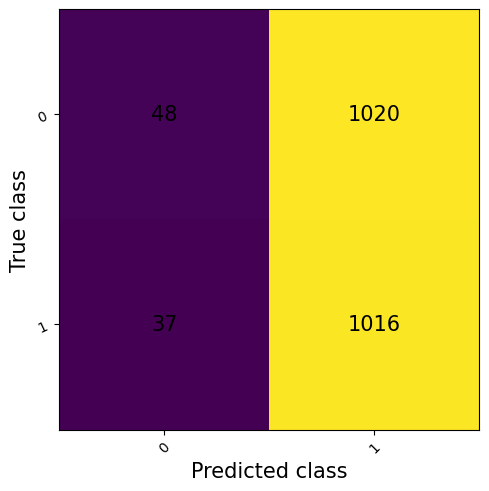

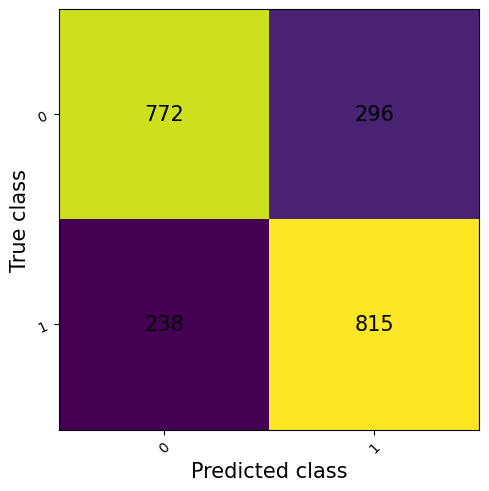

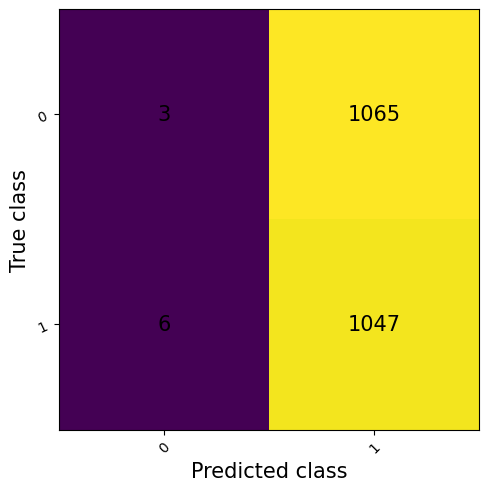

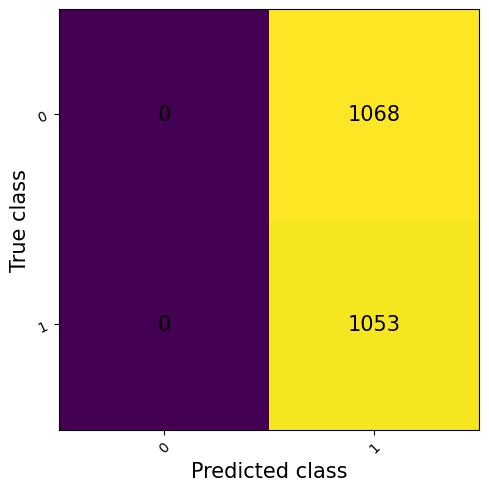

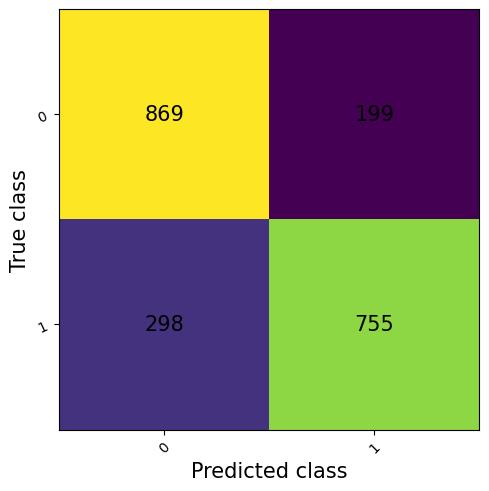

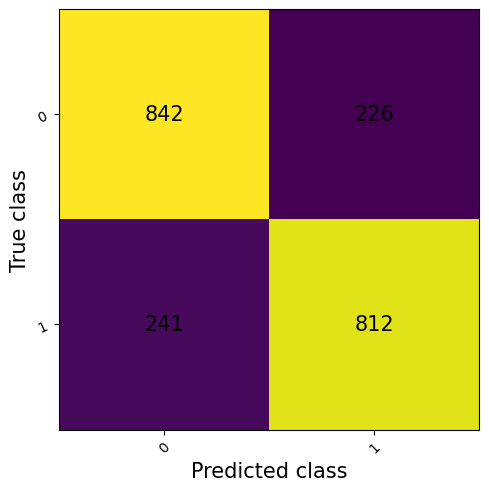

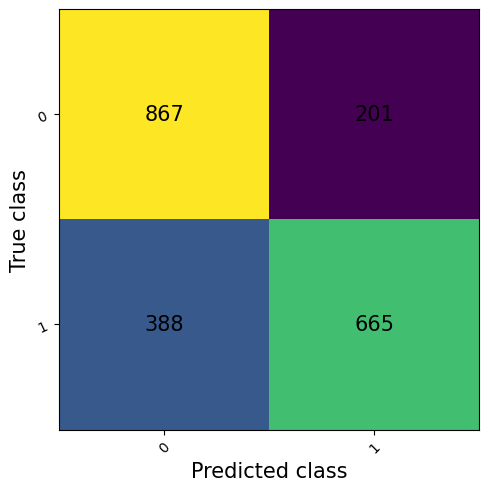

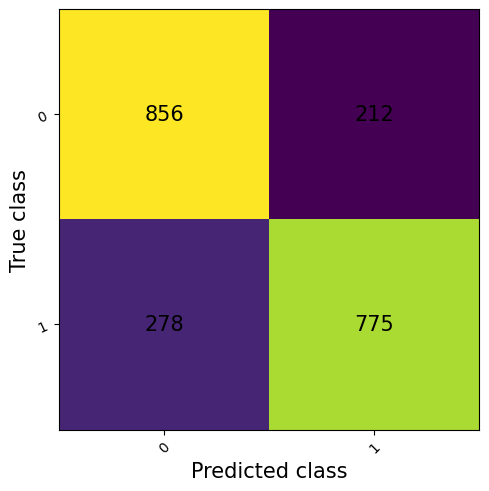

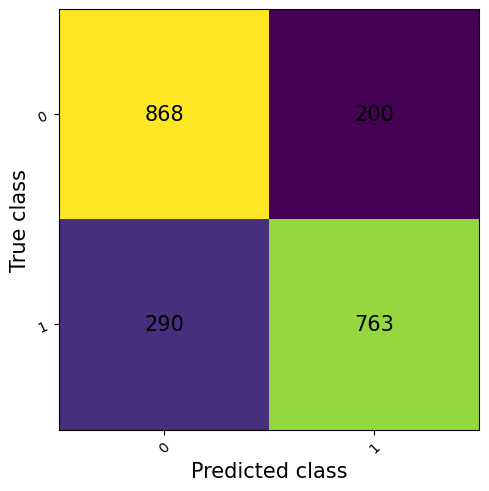

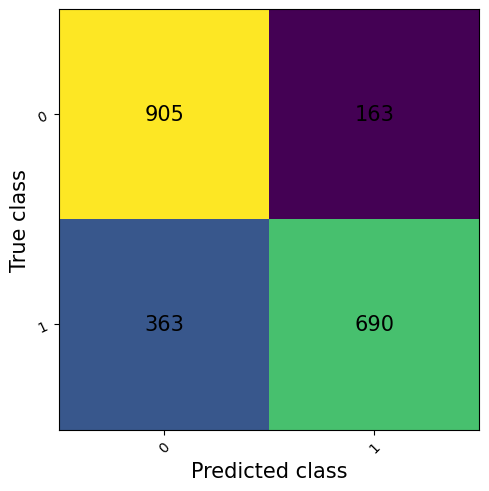

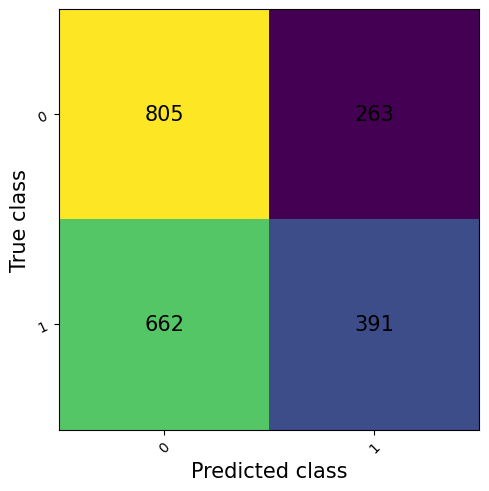

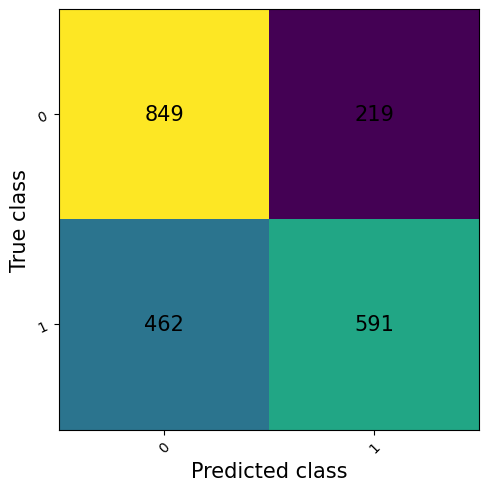

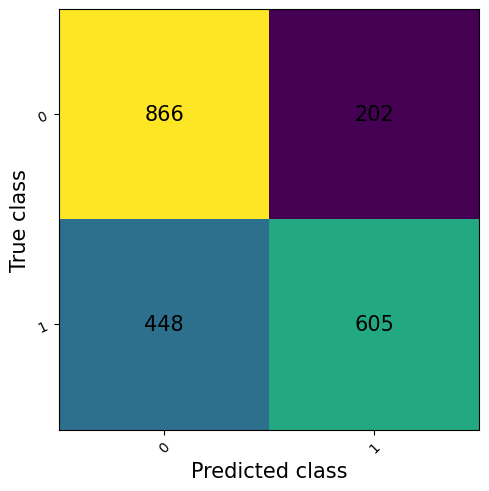

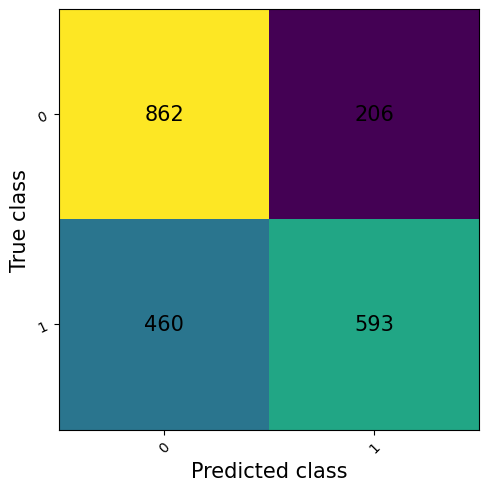

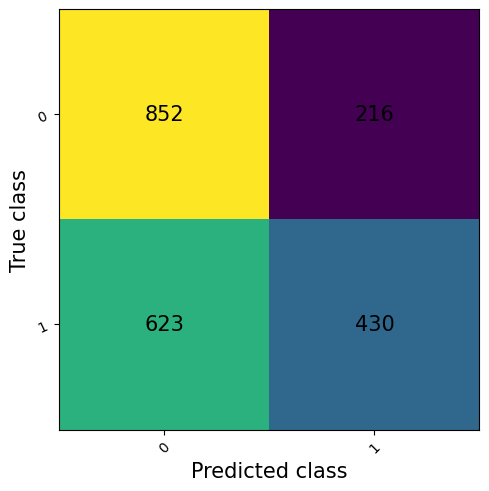

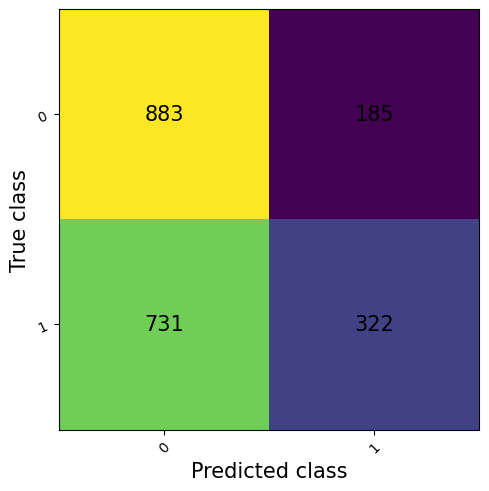

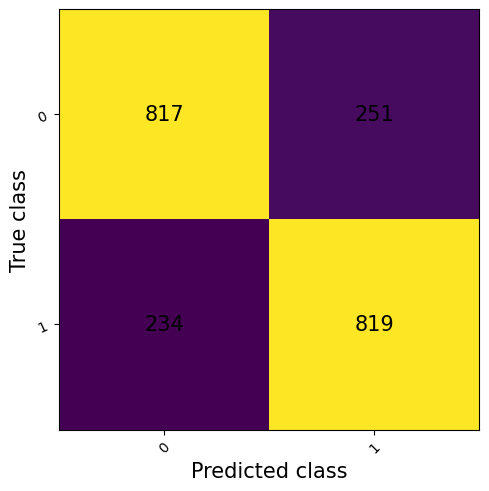

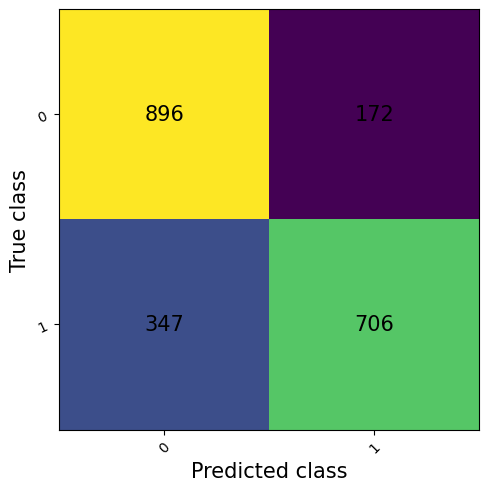

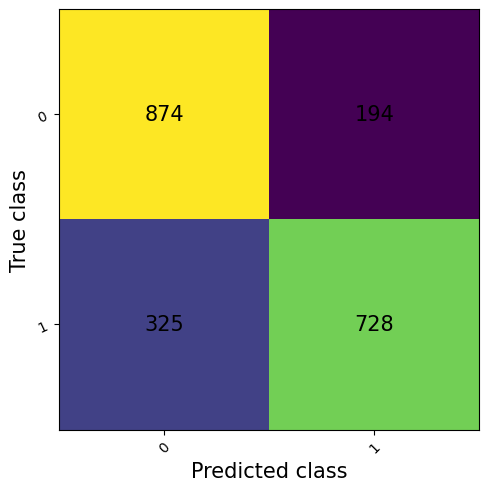

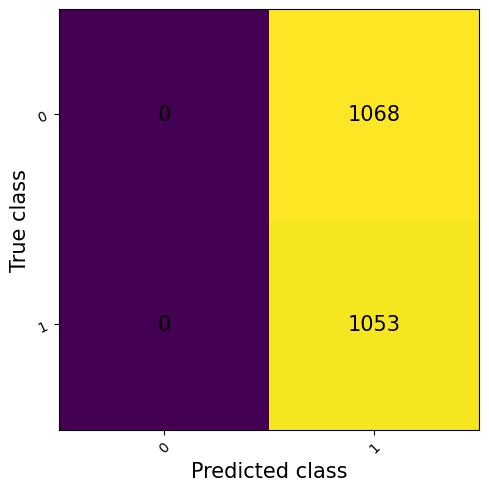

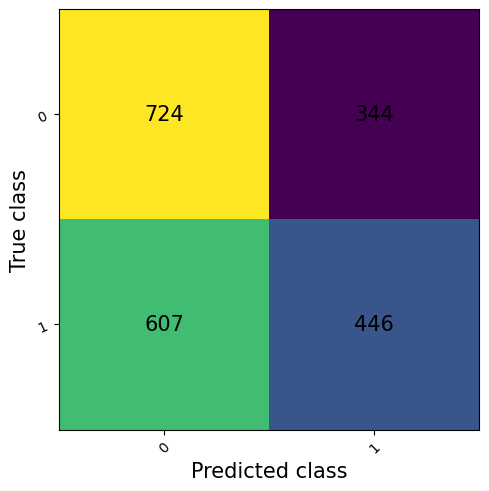

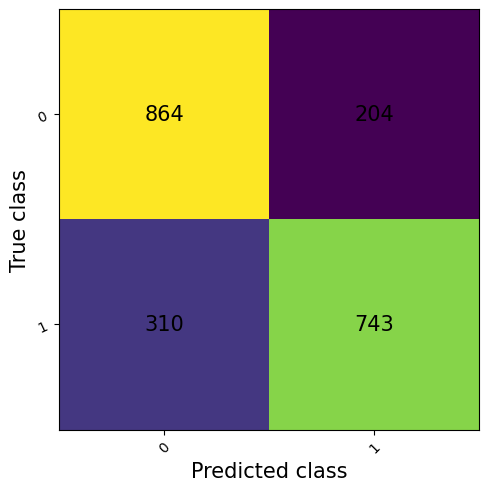

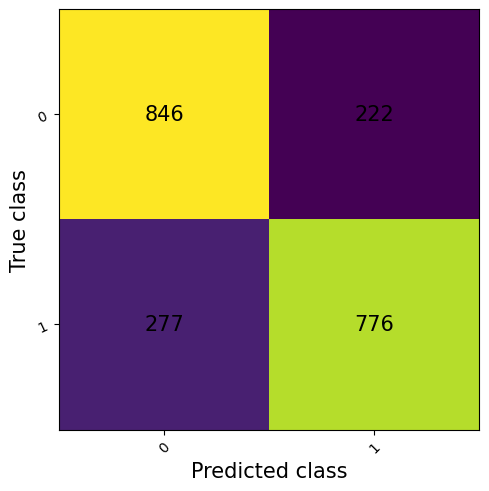

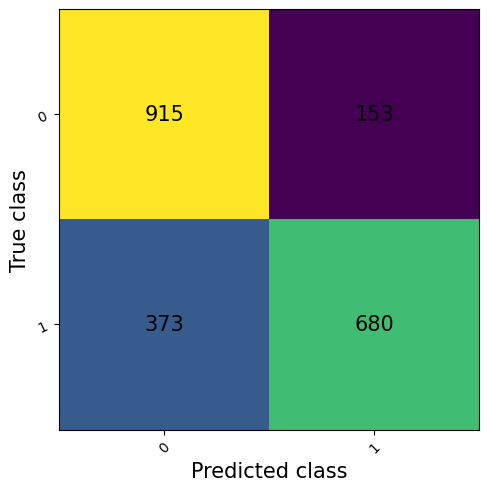

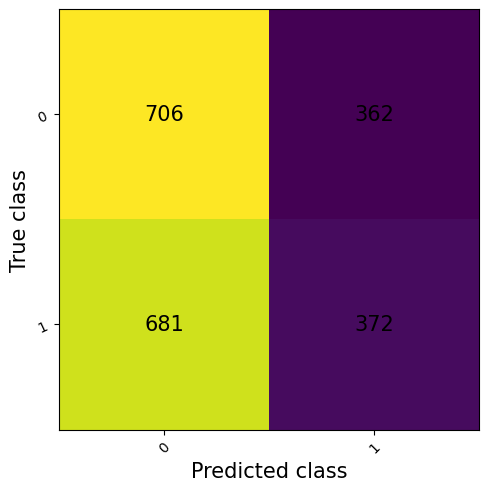

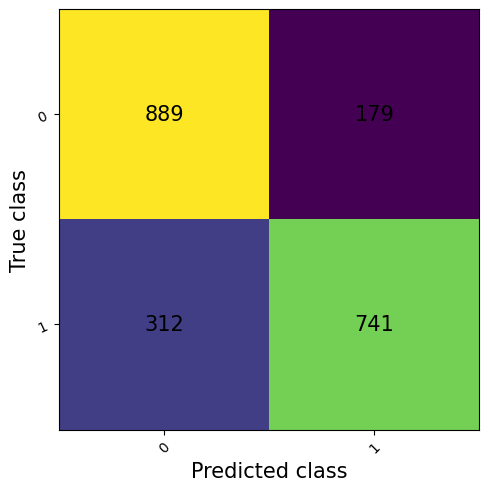

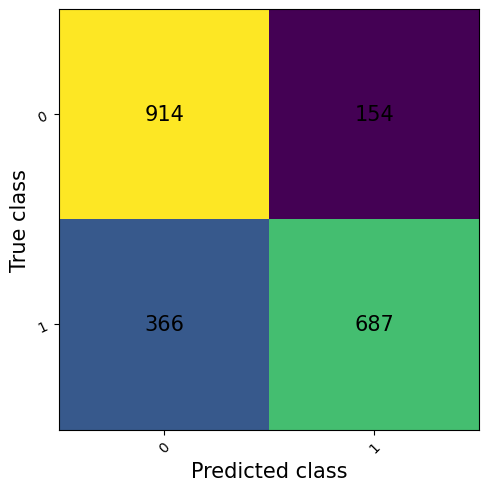

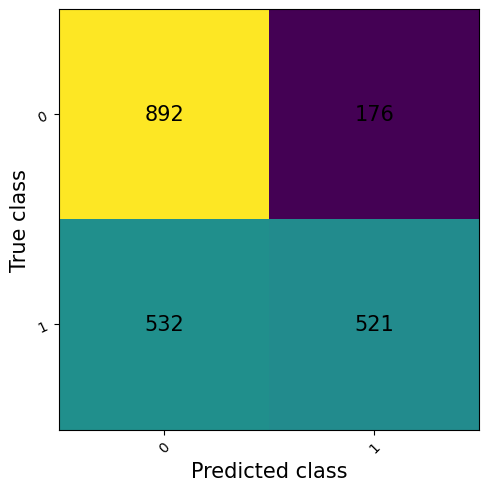

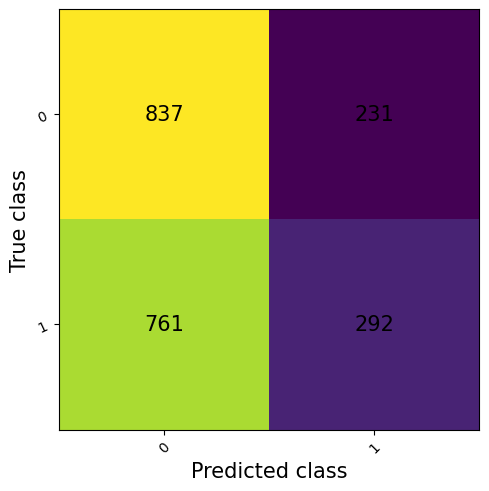

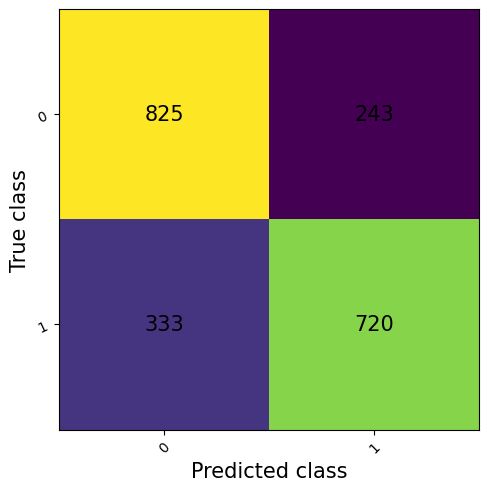

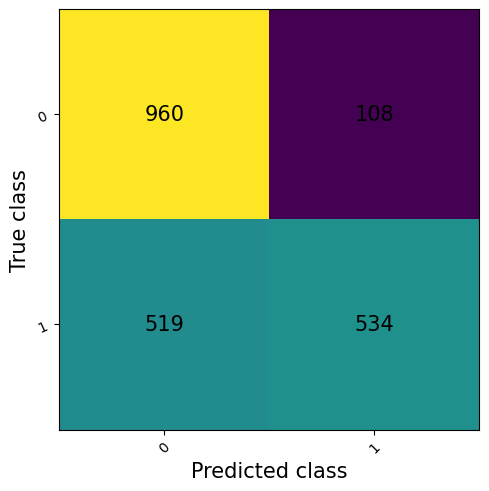

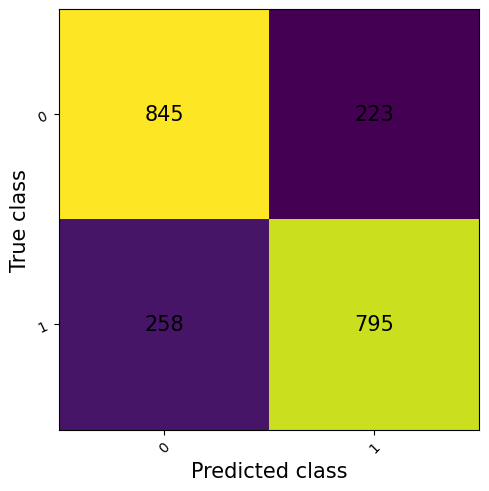

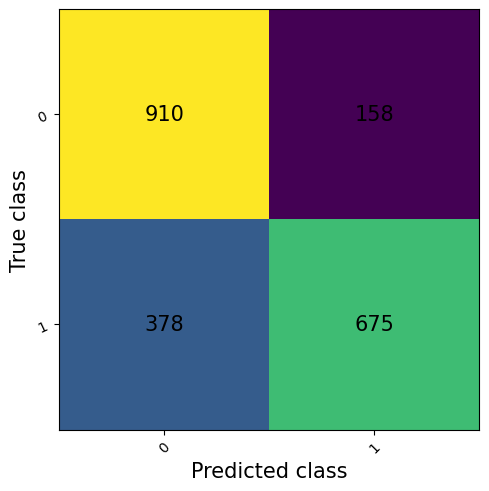

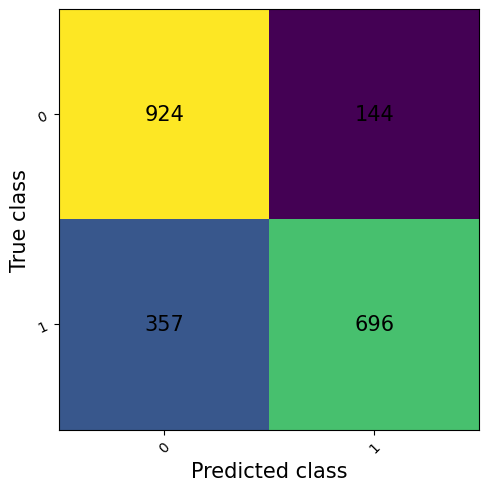

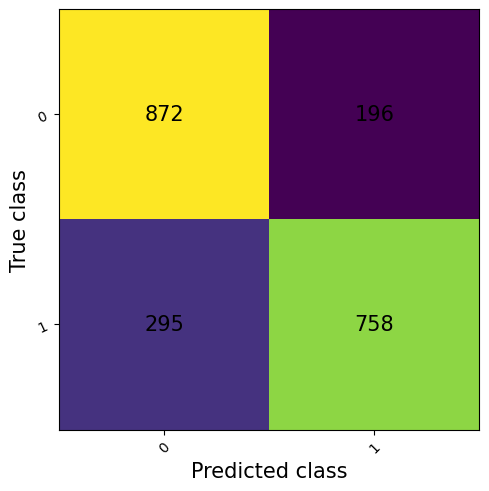

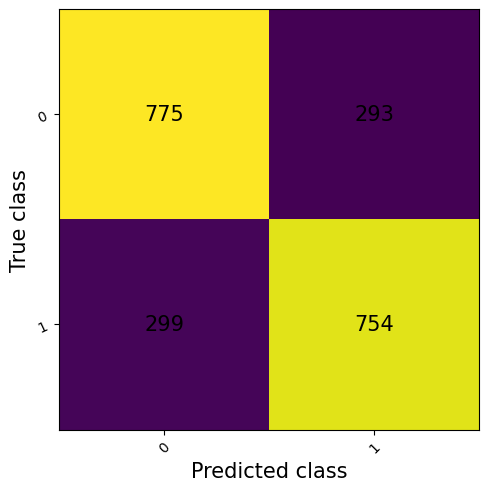

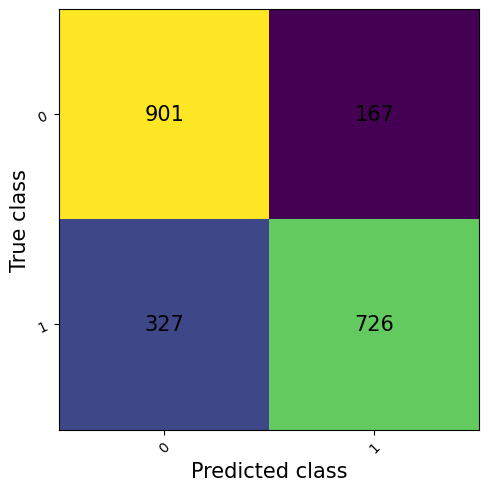

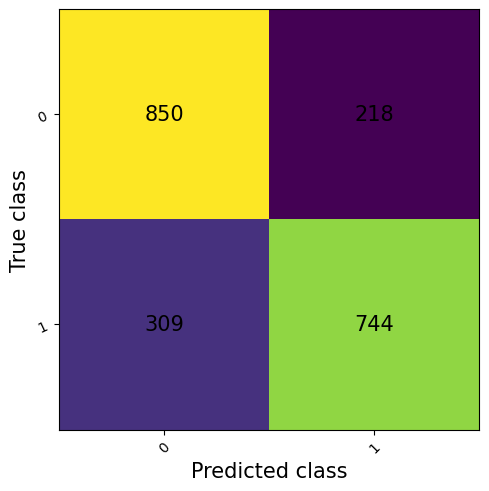

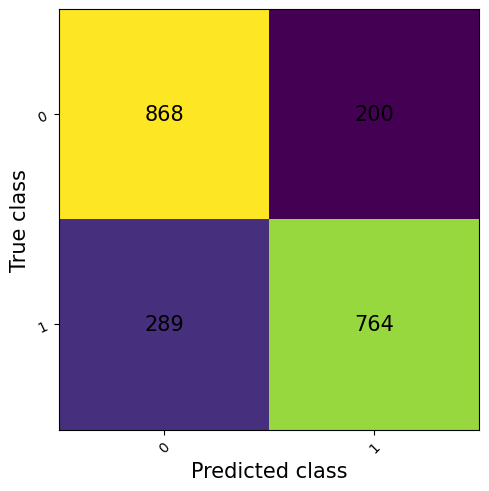

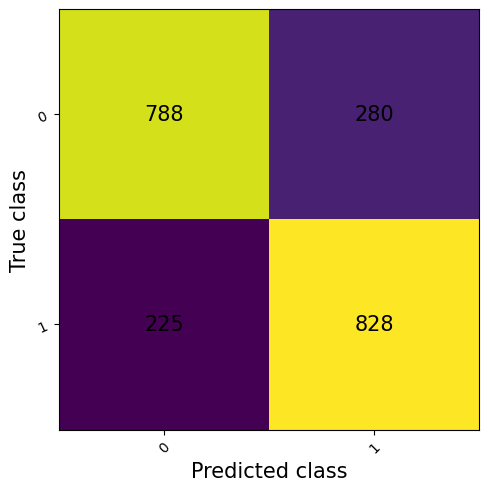

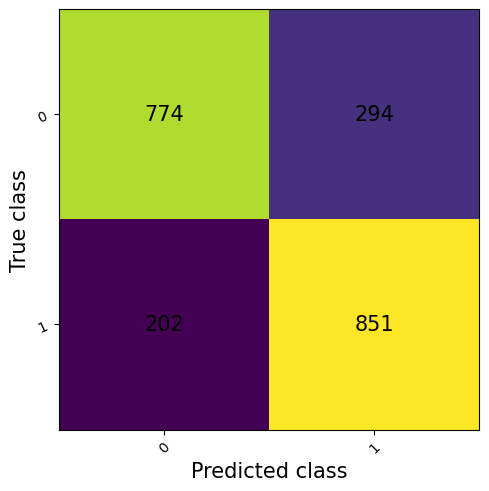

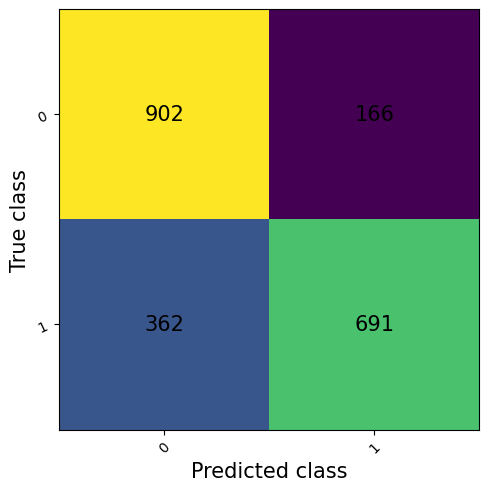

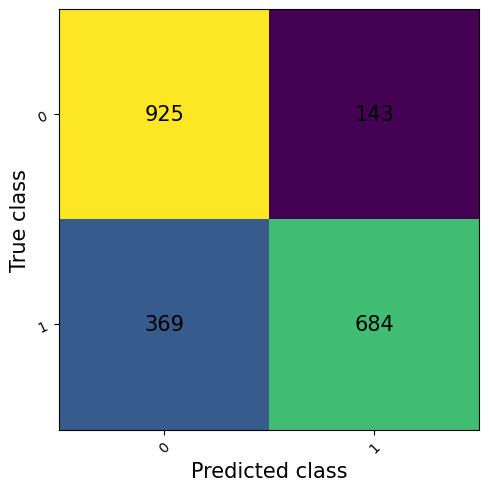

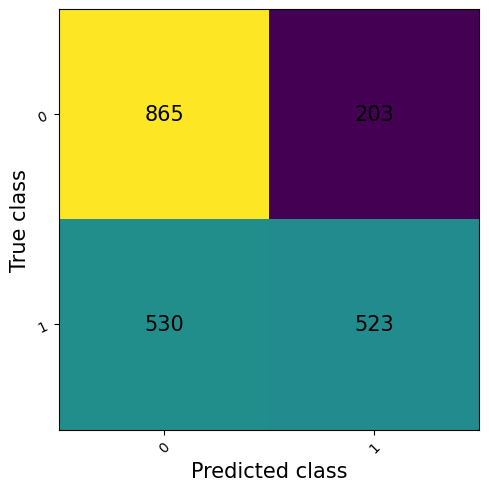

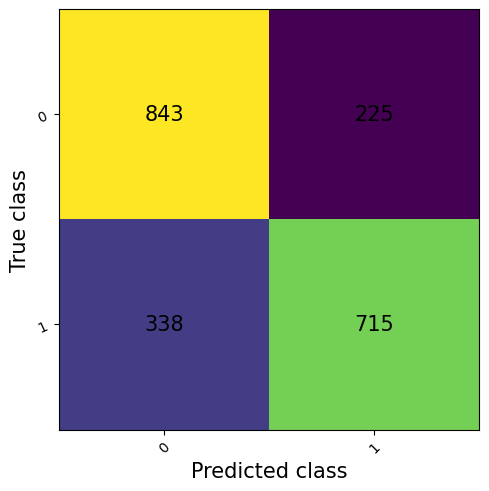

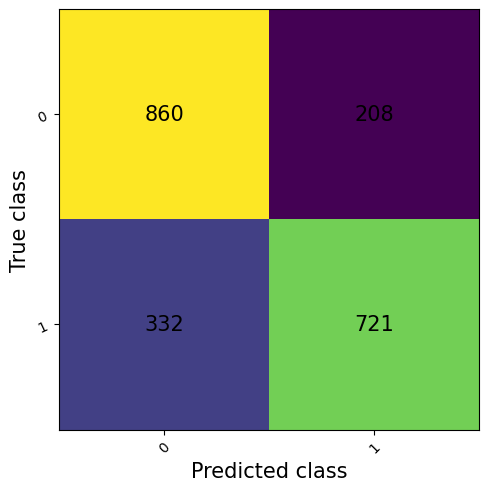

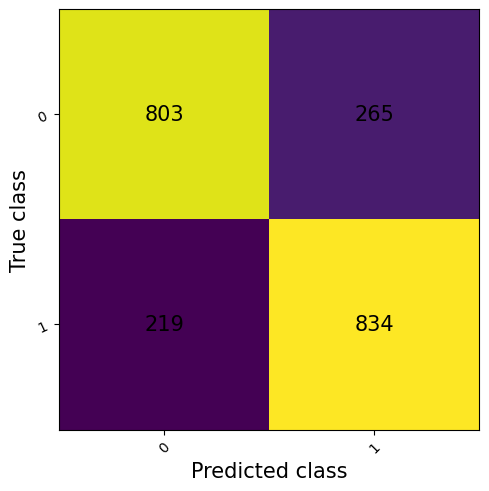

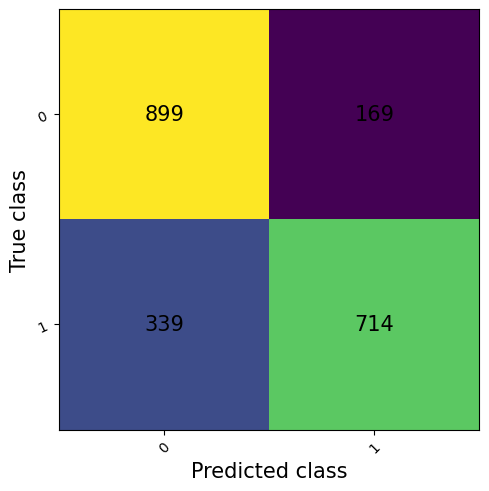

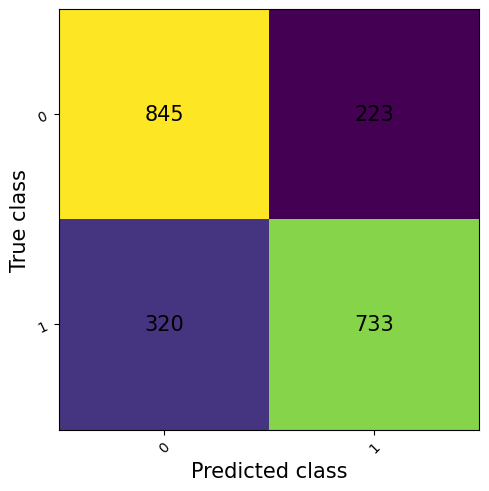

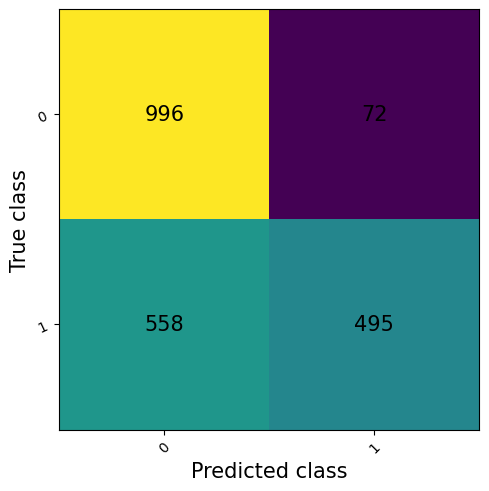

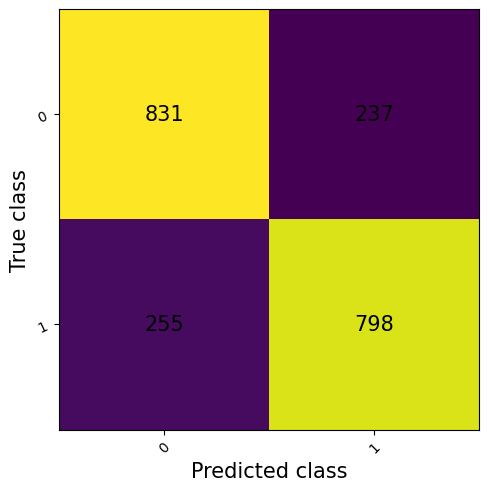

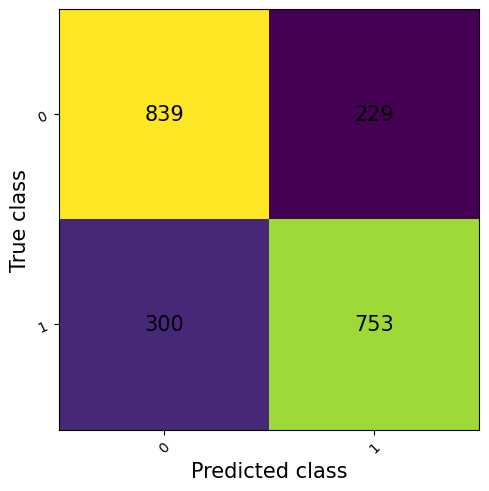

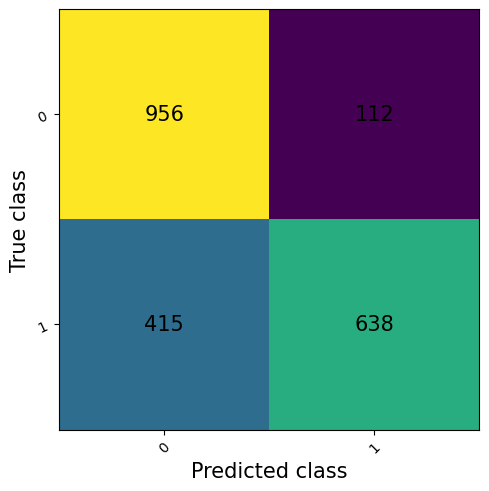

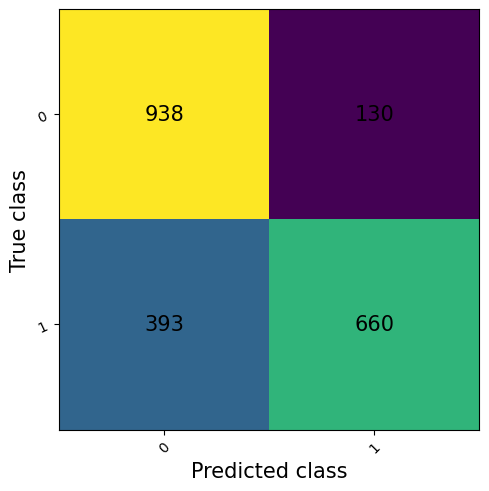

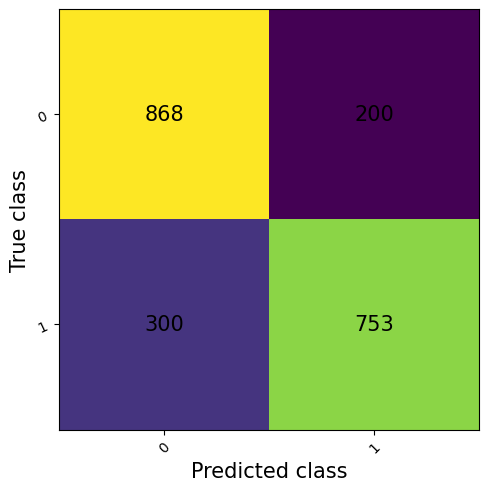

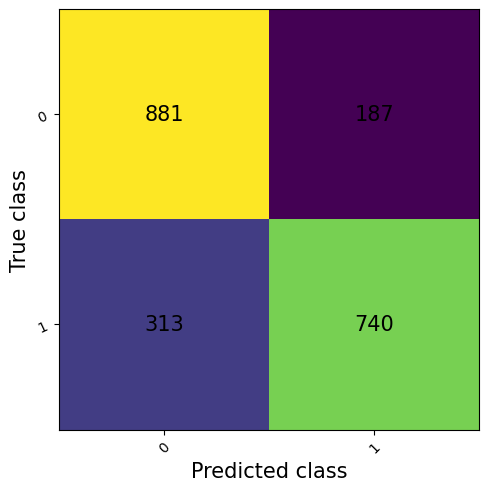

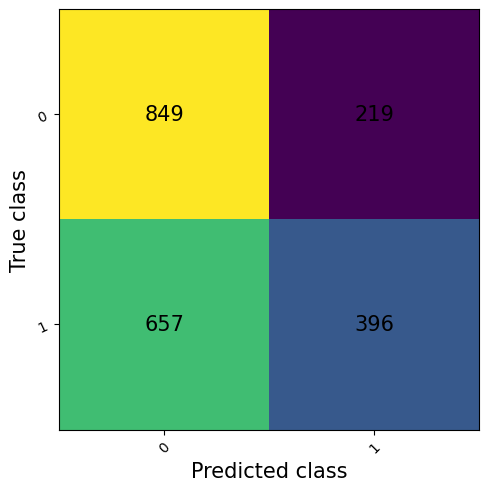

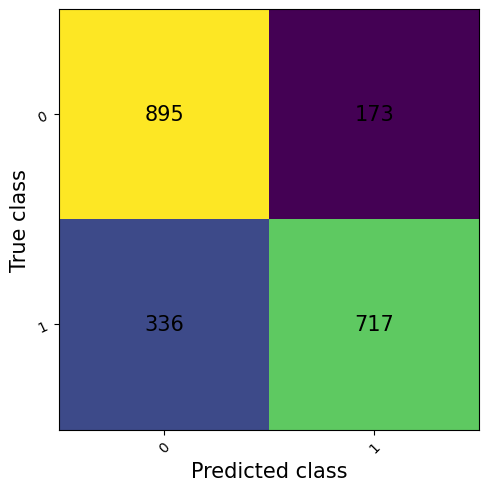

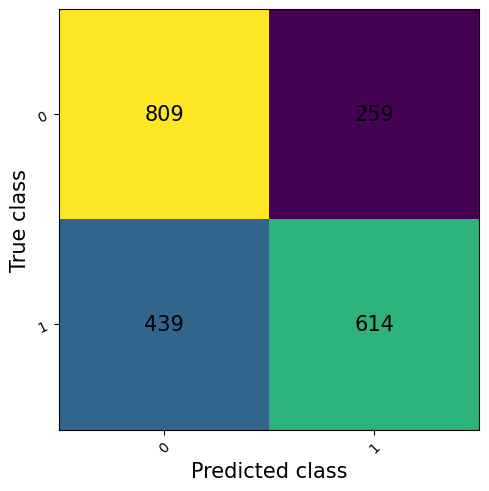

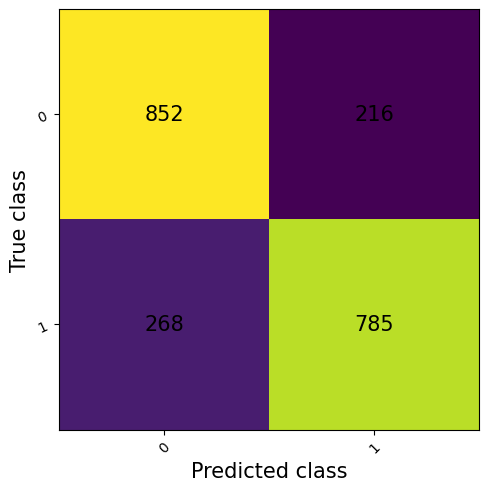

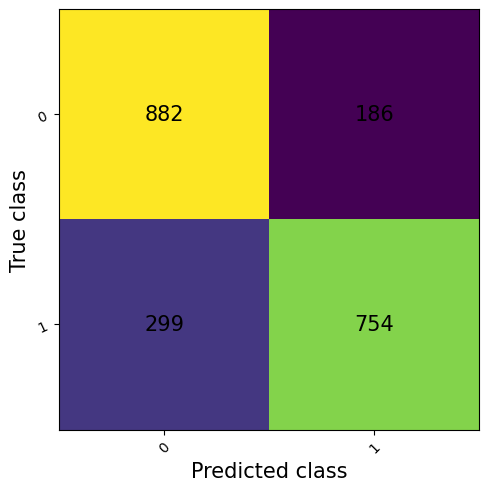

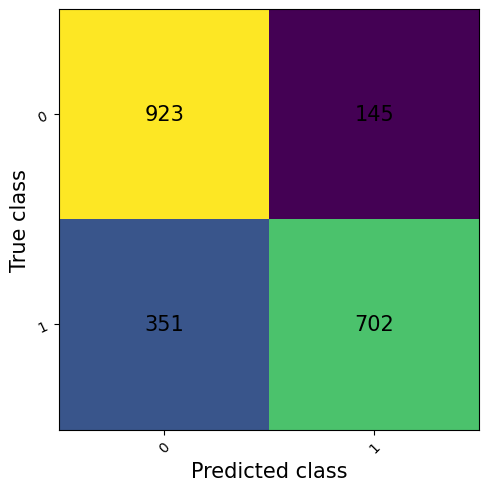

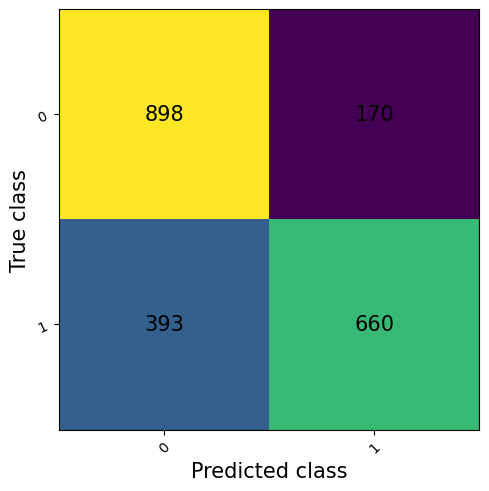

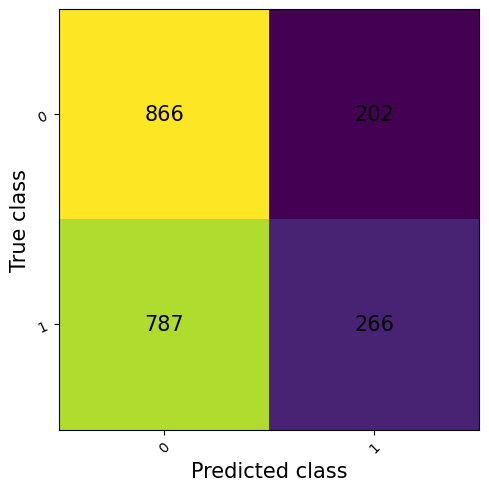

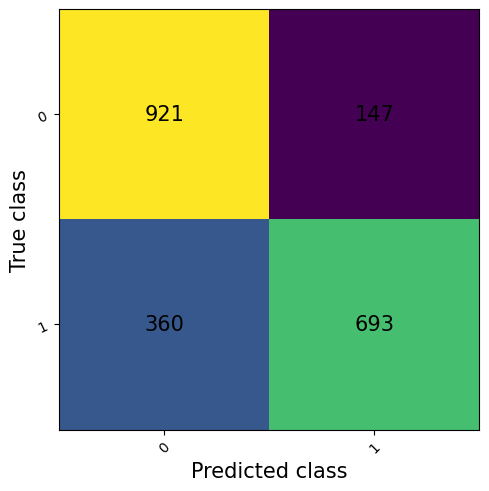

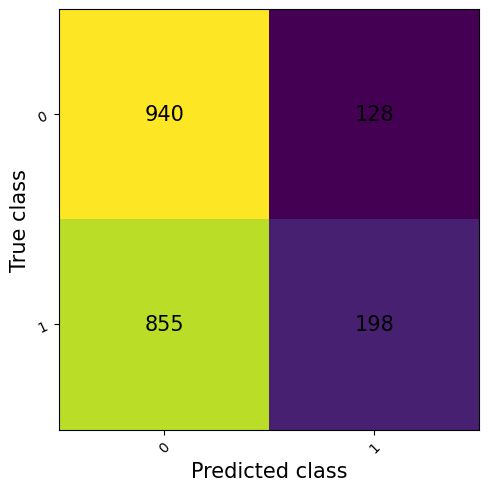

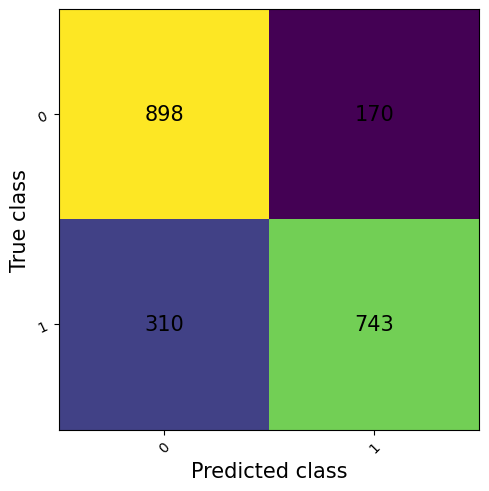

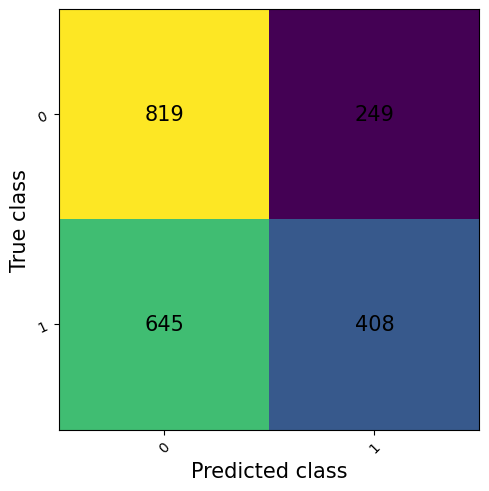

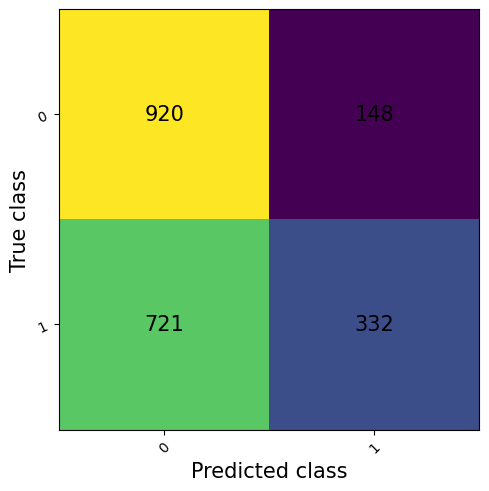

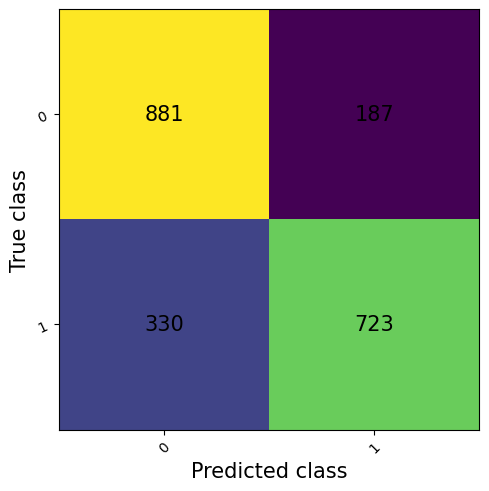

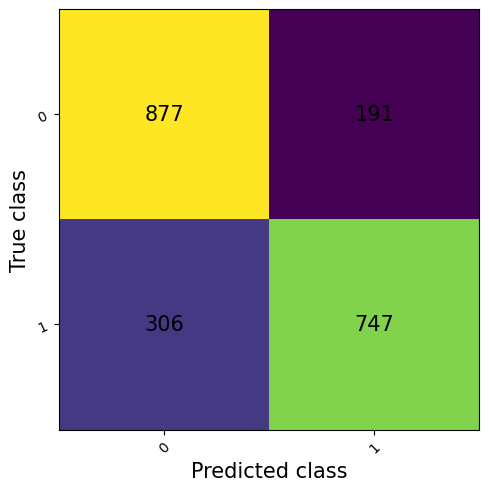

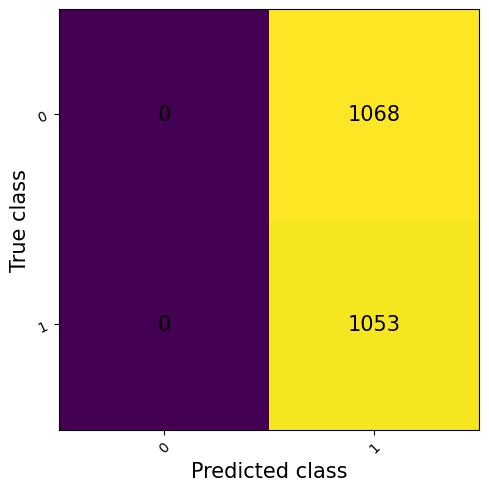

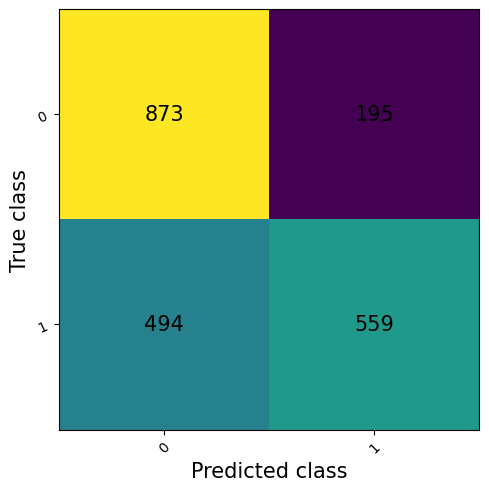

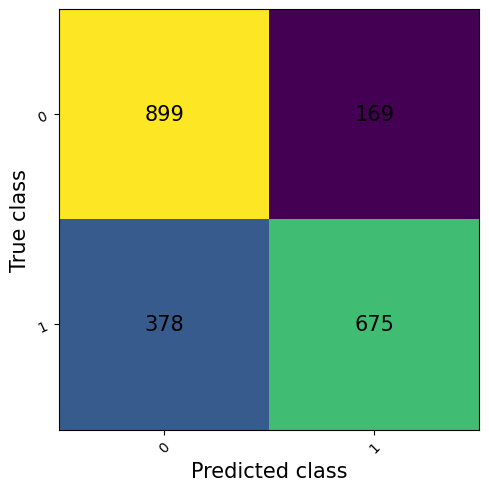

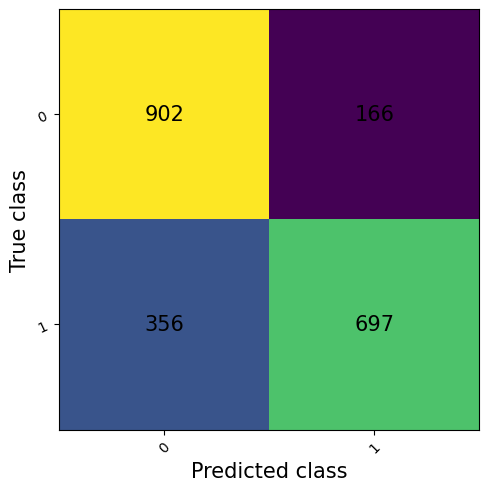

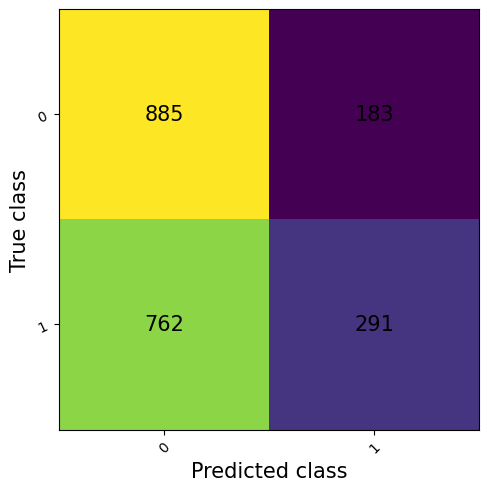

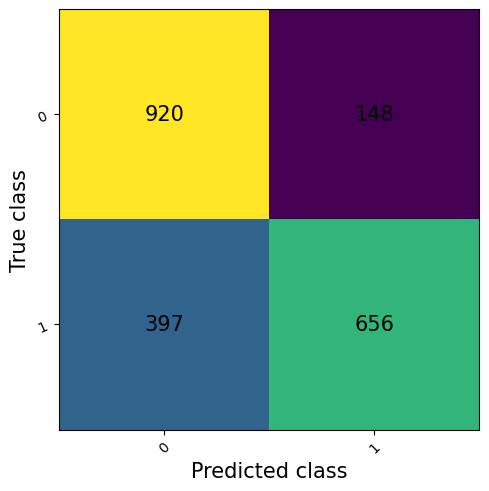

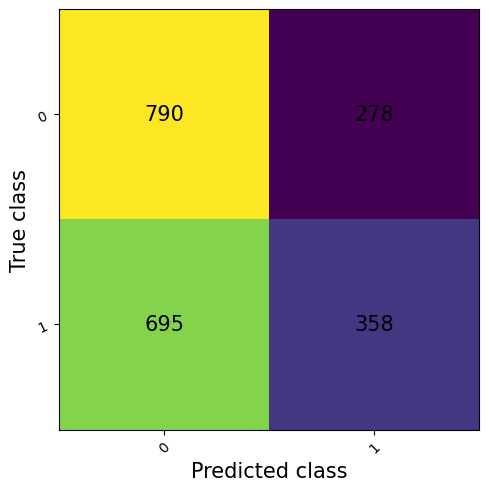

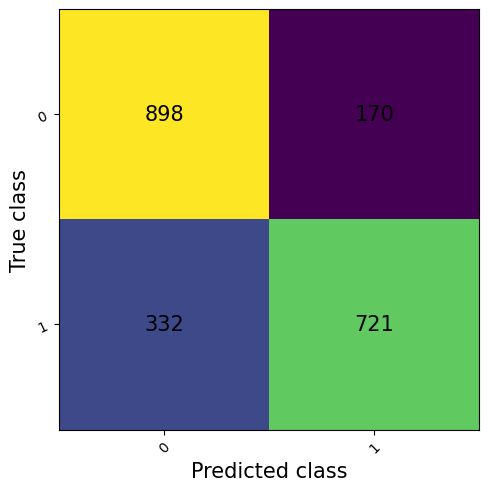

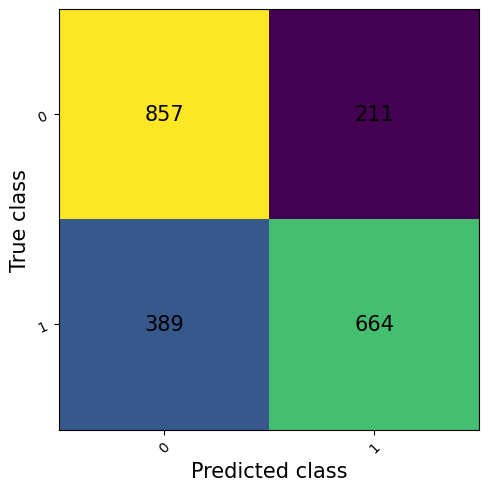

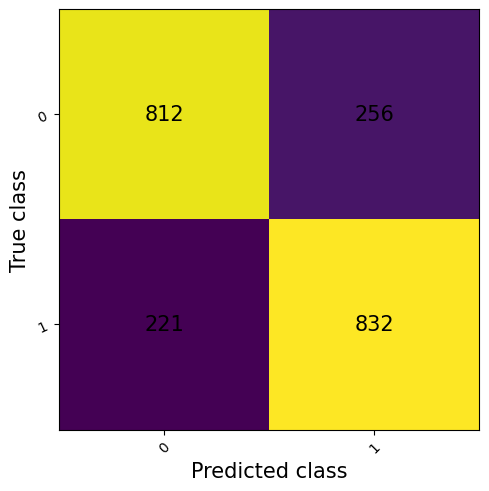

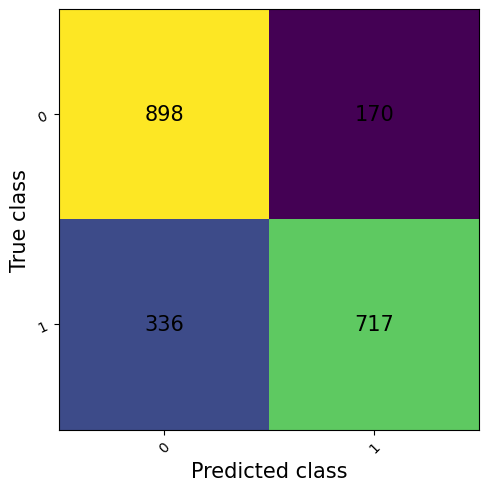

In [44]:
study.optimize(objective, n_trials=120,callbacks=[neptune_callback])

trial = study.best_trial

print('Best Value: {}'.format(trial.value))

print("Best hyperparameters: {}".format(trial.params))

In [45]:
save_optuna_states()
upload_optuna_states(run=run_study_level,directory="optuna")

In [46]:
run_study_level.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-2327/metadata
